In [2]:
!mkdir graph
!mkdir plot_G
!mkdir experiments_plt
!mkdir graph/test
!mkdir graph/train

mkdir: cannot create directory ‘graph’: File exists
mkdir: cannot create directory ‘plot_G’: File exists
mkdir: cannot create directory ‘experiments_plt’: File exists
mkdir: cannot create directory ‘graph/test’: File exists
mkdir: cannot create directory ‘graph/train’: File exists


In [3]:
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm

In [4]:
# 讀csv，回傳data frame
def DataLoader(file_name):
    df=pd.read_csv(file_name)
    print(df.shape)
    print(df.columns)
    return df

In [5]:

df=DataLoader('creditcard.csv')


(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [6]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

In [7]:
# 10:1的資料
def data_sampling(df):
    # print(df)
    fraud_data=df[df['Class']==1]
    normal_data=df[df['Class']==0].sample(n=len(fraud_data)*10,random_state=42)
    
    selected_df_eval=pd.concat([normal_data[:int(len(normal_data)*0.5)],fraud_data[:int(len(fraud_data)*0.5)]])
    selected_df_train=pd.concat([normal_data[int(len(normal_data)*0.5):],fraud_data[int(len(fraud_data)*0.5):]])
    
    selected_df_train.reset_index(drop=True,inplace=True)
    selected_df_eval.reset_index(drop=True,inplace=True)
    
    return selected_df_train, selected_df_eval

In [8]:
df_train, df_eval=data_sampling(df)

In [9]:
# 標準化
def data_standardization(df):
    # 假設 df 是你的 DataFrame，columns 是要標準化的欄位名稱列表
    columns_to_normalize = ['Time', 'Amount']  # 填入要標準化的欄位名稱
    # 初始化 StandardScaler 物件
    scaler = StandardScaler()
    # 對指定列進行標準化
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df



In [10]:
df_train=data_standardization(df_train)
df_eval=data_standardization(df_eval)

In [11]:
def calculate_cosine_similarity(df, type):
    features=df.drop("Class",axis=1)
    cos_sim=cosine_similarity(features)
    np.save("cos_sim_"+type+".npy",cos_sim)
    print("Cosine similarity calculation completed and saved.") 



In [12]:
calculate_cosine_similarity(df_train, "train")
calculate_cosine_similarity(df_eval, "eval")

Cosine similarity calculation completed and saved.
Cosine similarity calculation completed and saved.


In [13]:
cos_sim_train=np.load("cos_sim_train.npy")
cos_sim_eval=np.load("cos_sim_eval.npy")

In [14]:
def cos_sim_describe(cos_sim):
    # 計算每一列的統計量
    max_values = np.max(cos_sim, axis=1)
    min_values = np.min(cos_sim, axis=1)
    median_values = np.median(cos_sim, axis=1)
    mean_values = np.mean(cos_sim, axis=1)
    std_values = np.std(cos_sim, axis=1)

    # 對這些統計量再次計算統計量
    stats_max = np.max(max_values)
    stats_min = np.min(min_values)
    stats_median = np.median(median_values)
    stats_mean = np.mean(mean_values)
    stats_std = np.std(std_values)

    # 印出結果
    print("Statistics of row statistics:")
    print("  Max:", stats_max)
    print("  Min:", stats_min)
    print("  Median:", stats_median)
    print("  Mean:", stats_mean)
    print("  Std:", stats_std)
    cos_sim_dict={'max':stats_max,'min':stats_min,'median':stats_median
                  ,'mean':stats_mean,'std':stats_std}
    return cos_sim_dict

In [15]:
cos_sim_dict_train=cos_sim_describe(cos_sim_train)
print(cos_sim_dict_train)

Statistics of row statistics:
  Max: 1.000000000000001
  Min: -0.8572316303335384
  Median: -0.018842568596350195
  Mean: 0.008535455996748402
  Std: 0.03189522908476312
{'max': 1.000000000000001, 'min': -0.8572316303335384, 'median': -0.018842568596350195, 'mean': 0.008535455996748402, 'std': 0.03189522908476312}


In [16]:
cos_sim_dict_eval =cos_sim_describe(cos_sim_eval)
print(cos_sim_dict_eval)

Statistics of row statistics:
  Max: 1.000000000000001
  Min: -0.8285081544414731
  Median: -0.022723522704163657
  Mean: 0.007399144436756456
  Std: 0.0313912742638381
{'max': 1.000000000000001, 'min': -0.8285081544414731, 'median': -0.022723522704163657, 'mean': 0.007399144436756456, 'std': 0.0313912742638381}


In [17]:
## graph construction
import networkx as nx

In [18]:
def graph_construction(cos_sim,df,threshold):
    G=nx.Graph()
    for i in tqdm(range(cos_sim.shape[0]),desc="Add nodes into G..."):
        node_name=i
        feature=(df.iloc[i]).to_dict()
        G.add_node(node_name,**feature)

    for i in tqdm(range(cos_sim.shape[0]),desc="Graph Construction..."):
        for j in range(i+1,cos_sim.shape[1]):
            if cos_sim[i,j]>threshold:
                G.add_edge(i,j)
    return G


In [19]:
from collections import Counter
def graph_describe(G,round_digit):
    density=2*G.number_of_edges()/(G.number_of_nodes()*(G.number_of_nodes()-1))
    # 获取节点的度数
    degrees = [degree for node, degree in G.degree()]
    # 计算统计指标
    mean_degree = np.mean(degrees)
    median_degree = np.median(degrees)
    std_degree = np.std(degrees)
    max_degree = np.max(degrees)
    min_degree = np.min(degrees)
    
    edge_consistency={}
    fraud_node_set=set()
    for edge in tqdm(G.edges(),desc="Check edge consistent..."):
        node1_class=G.nodes[edge[0]]['Class']
        node2_class=G.nodes[edge[1]]['Class']

        if node1_class==node2_class:
            edge_consistency[edge]=1
        else:
            edge_consistency[edge]=0

    value_counts=Counter(edge_consistency.values())
    ratio=value_counts[0]/G.number_of_edges()
    return G.number_of_nodes(),G.number_of_edges(),density,mean_degree,median_degree,std_degree,max_degree,min_degree,ratio

In [20]:
import pickle

def save_graph(name, G):
    # save graph object to file
    pickle.dump(G, open("graph/"+name+'.pickle', 'wb'))

def load_graph(name, G):
    # load graph object from file
    G = pickle.load(open("graph/"+name+'.pickle', 'rb'))
    return G

In [21]:
def data_construction(type, cos_sim, cos_sim_dict_train):
    data_dic={'threshold':[],'number_of_nodes':[],'number_of_edges':[],'density':[]
              ,'mean_degree':[],'median_degree':[],'std_of_degree':[],'max_degree':[]
              ,'min_degree':[],'ratio_of_heterogeneous':[]}
    graph=[]
    for factor in range(31):
        # threshold
        threshold=cos_sim_dict_train['median']+factor*cos_sim_dict_train['std']
        data_dic['threshold'].append(threshold)
        G=graph_construction(cos_sim,df,threshold)
        graph.append(G)
        # 存graph
        save_graph(type+"/"+str(threshold), G)
        
        non,noe,d,meand,medd,stdd,maxd,mind,ratio=graph_describe(G,3)
        data_dic['number_of_nodes'].append(non)
        data_dic['number_of_edges'].append(noe)
        data_dic['density'].append(d)
        data_dic['mean_degree'].append(meand)
        data_dic['median_degree'].append(medd)
        data_dic['std_of_degree'].append(stdd)
        data_dic['max_degree'].append(maxd)
        data_dic['min_degree'].append(mind)
        data_dic['ratio_of_heterogeneous'].append(ratio)
    
    return graph, data_dic



In [22]:
graph, data_dic = data_construction("train", cos_sim_train, cos_sim_dict_train)
# !!!!test也用train的相似度去計算threshold
graph_test, data_dic_test = data_construction("test", cos_sim_eval, cos_sim_dict_train)

Check edge consistent...: 100%|██████████| 3635/3635 [00:00<00:00, 817495.71it/s]


In [23]:
# 存成data.json
import json
def save_data_dic(type, data_dic):
    for key in data_dic:
        if isinstance(data_dic[key][0], np.int32) or isinstance(data_dic[key][0], np.int64):
            data_dic[key]=[int(num) for num in data_dic[key]]
        elif isinstance(data_dic[key][0], np.float64):
            data_dic[key]=[float(num) for num in data_dic[key]]
    json_data=json.dumps(data_dic,indent=4)
    with open('data_'+type+'.json','w') as json_file:
        json_file.write(json_data)
    with open("data.json",'r') as json_file:
        data_dic=json.load(json_file)
    # type_list=[]
    # for key in data_dic:
    #     print(f"{key}:")
    #     print([round(num,3) for num in data_dic[key]])
    #     print(f"type:{type(data_dic[key][0])}")
    #     type_list.append(type(data_dic[key][0]))
    #     print()
    # print(type_list)

In [24]:
data_dic

{'threshold': [-0.018842568596350195,
  0.013052660488412922,
  0.04494788957317604,
  0.07684311865793916,
  0.10873834774270227,
  0.14063357682746538,
  0.17252880591222852,
  0.20442403499699163,
  0.23631926408175474,
  0.26821449316651785,
  0.30010972225128096,
  0.3320049513360441,
  0.36390018042080724,
  0.39579540950557035,
  0.42769063859033346,
  0.45958586767509657,
  0.4914810967598597,
  0.5233763258446229,
  0.5552715549293858,
  0.587166784014149,
  0.6190620130989122,
  0.6509572421836753,
  0.6828524712684383,
  0.7147477003532015,
  0.7466429294379646,
  0.7785381585227278,
  0.810433387607491,
  0.8423286166922539,
  0.8742238457770171,
  0.9061190748617802,
  0.9380143039465434],
 'number_of_nodes': [2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706],
 'number_of_edges': 

In [25]:
data_dic_test

{'threshold': [-0.018842568596350195,
  0.013052660488412922,
  0.04494788957317604,
  0.07684311865793916,
  0.10873834774270227,
  0.14063357682746538,
  0.17252880591222852,
  0.20442403499699163,
  0.23631926408175474,
  0.26821449316651785,
  0.30010972225128096,
  0.3320049513360441,
  0.36390018042080724,
  0.39579540950557035,
  0.42769063859033346,
  0.45958586767509657,
  0.4914810967598597,
  0.5233763258446229,
  0.5552715549293858,
  0.587166784014149,
  0.6190620130989122,
  0.6509572421836753,
  0.6828524712684383,
  0.7147477003532015,
  0.7466429294379646,
  0.7785381585227278,
  0.810433387607491,
  0.8423286166922539,
  0.8742238457770171,
  0.9061190748617802,
  0.9380143039465434],
 'number_of_nodes': [2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706,
  2706],
 'number_of_edges': 

In [26]:
save_data_dic("train", data_dic)
save_data_dic("test", data_dic_test)

plot...: 0it [00:00, ?it/s]/tmp/ipykernel_59216/3776892845.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  subset_nodes = random.sample(G.nodes(), k=30)
plot...: 20it [00:05,  5.54it/s]/tmp/ipykernel_59216/3776892845.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))
plot...: 31it [00:06,  4.69it/s]


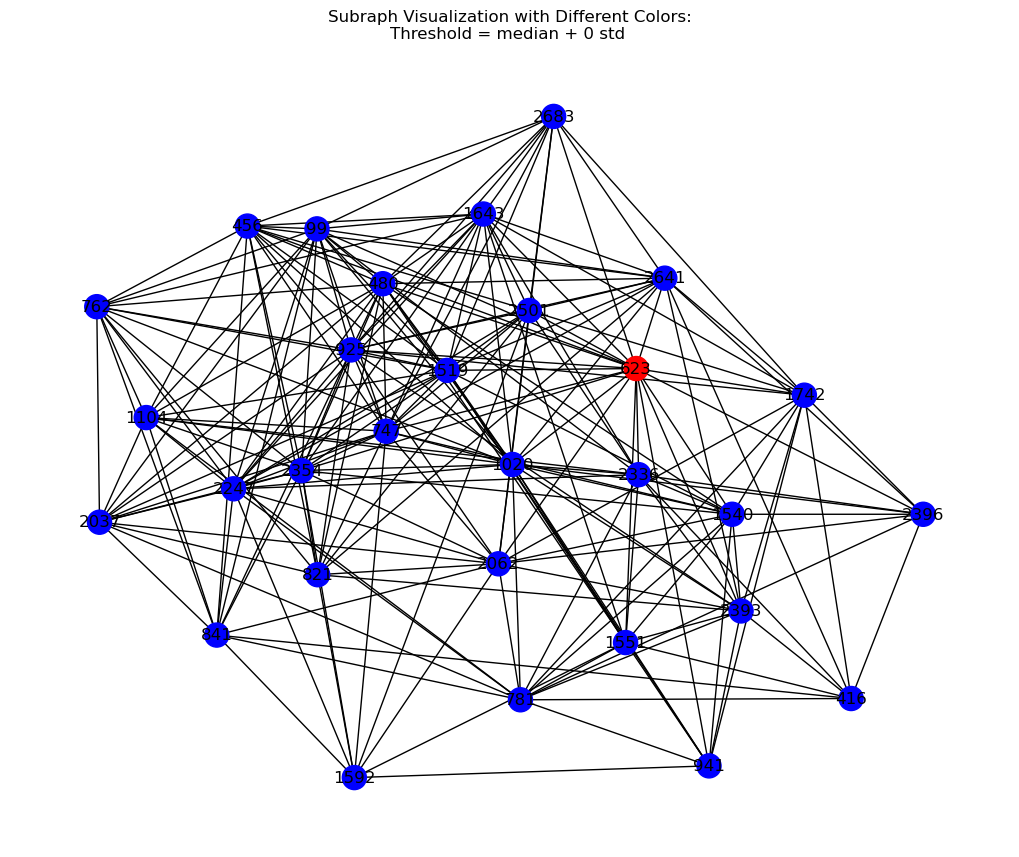

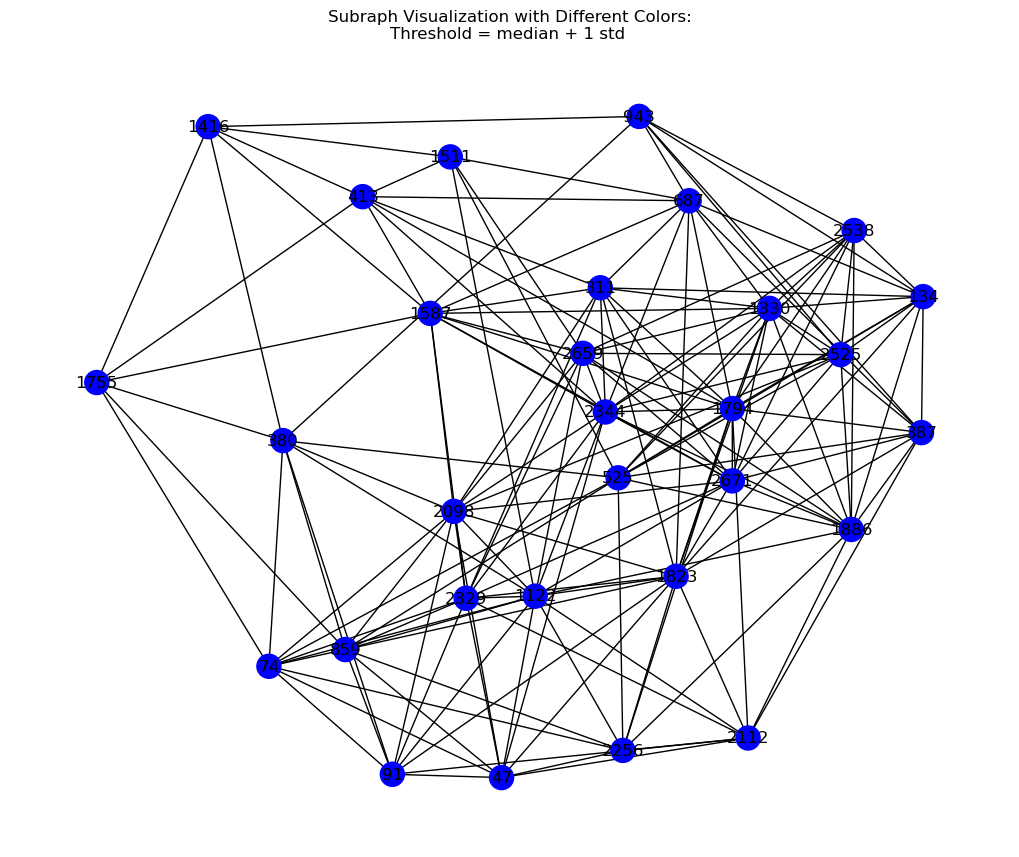

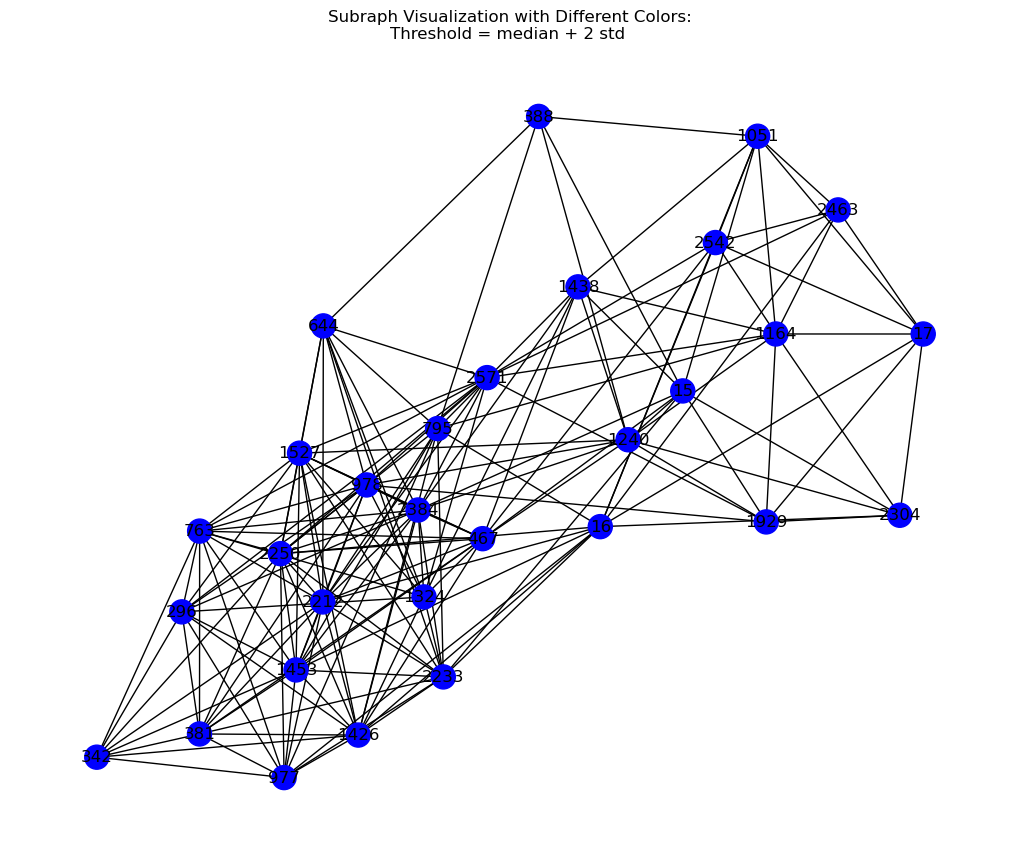

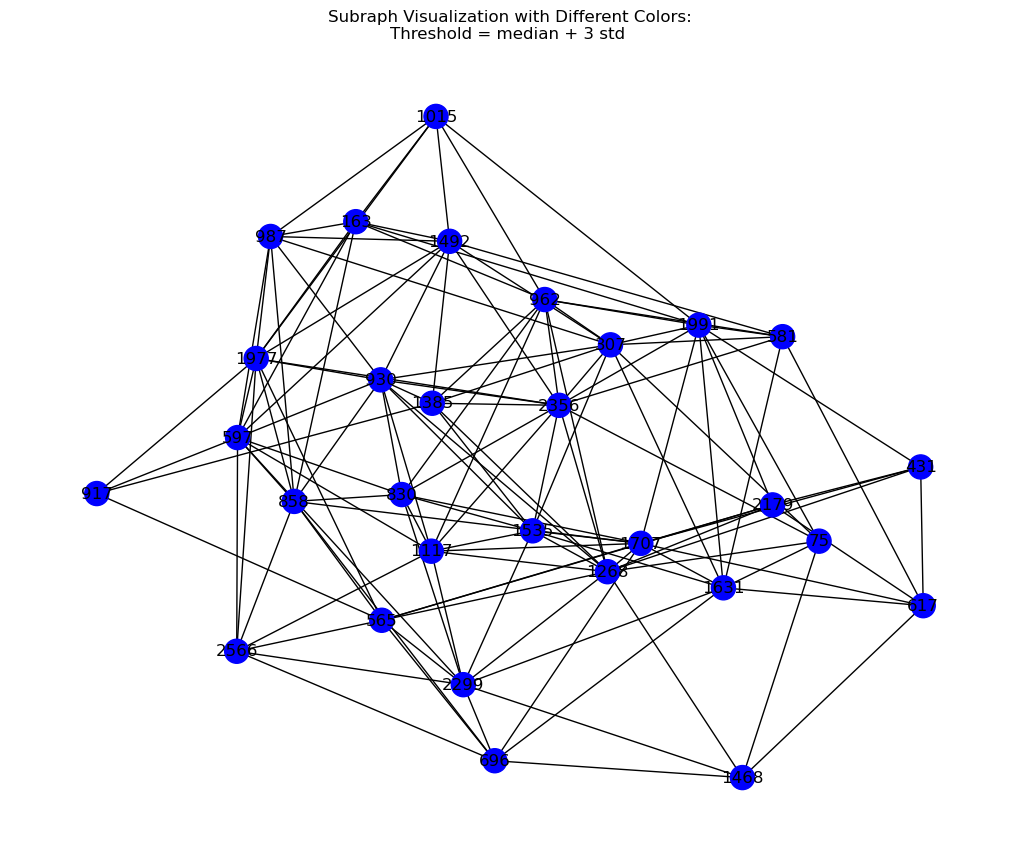

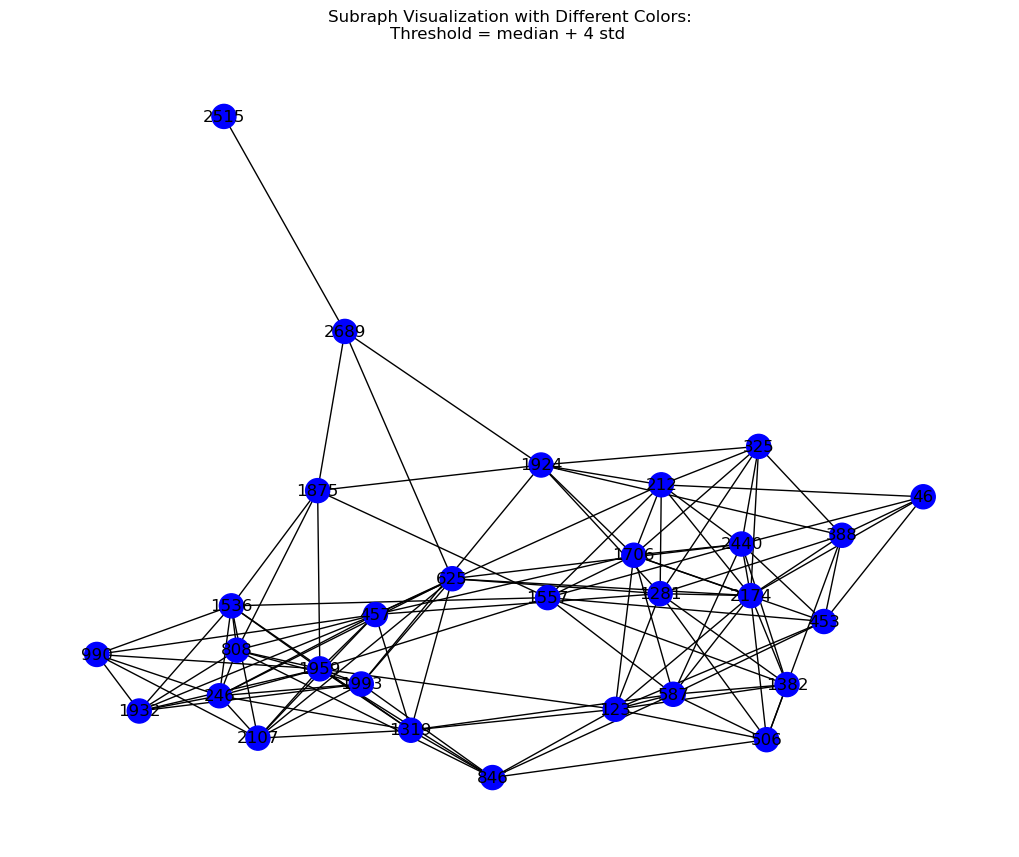

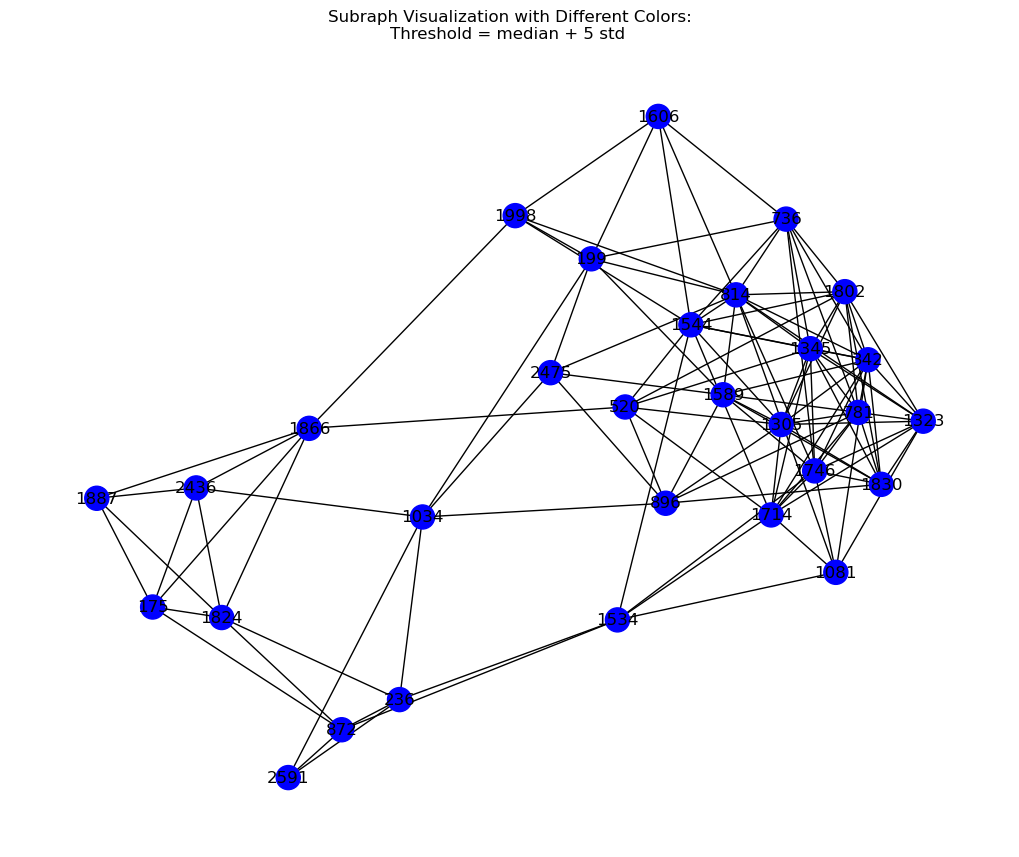

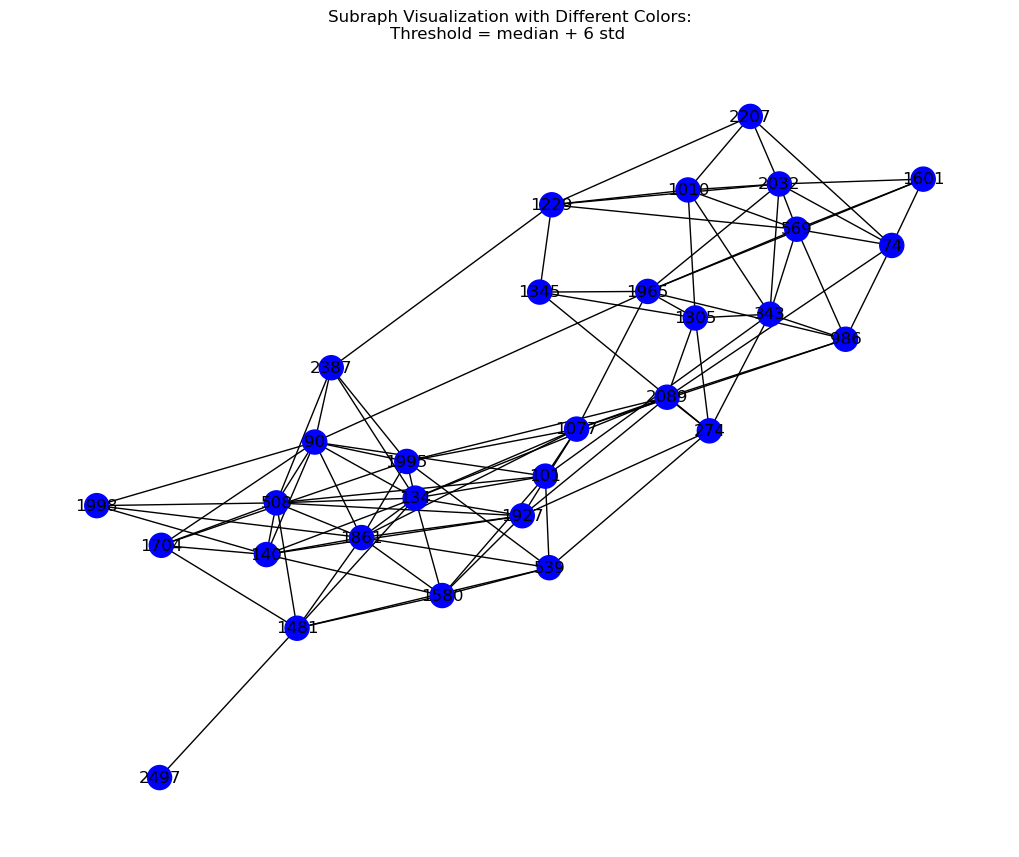

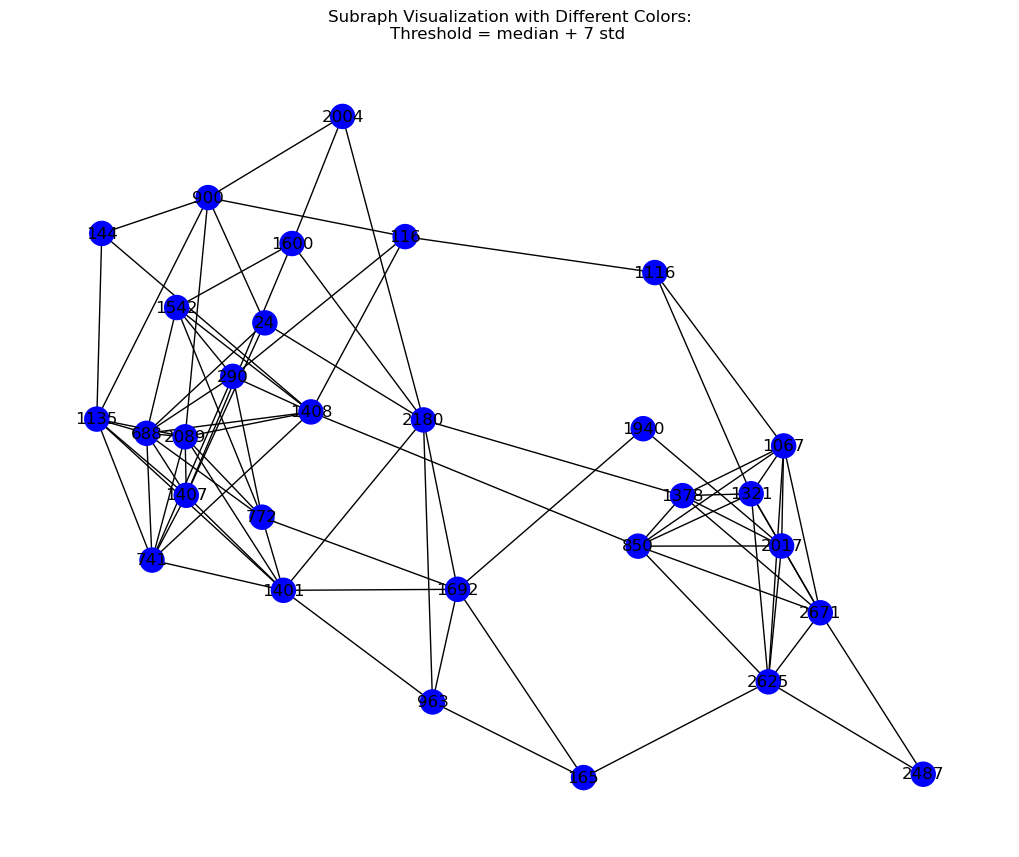

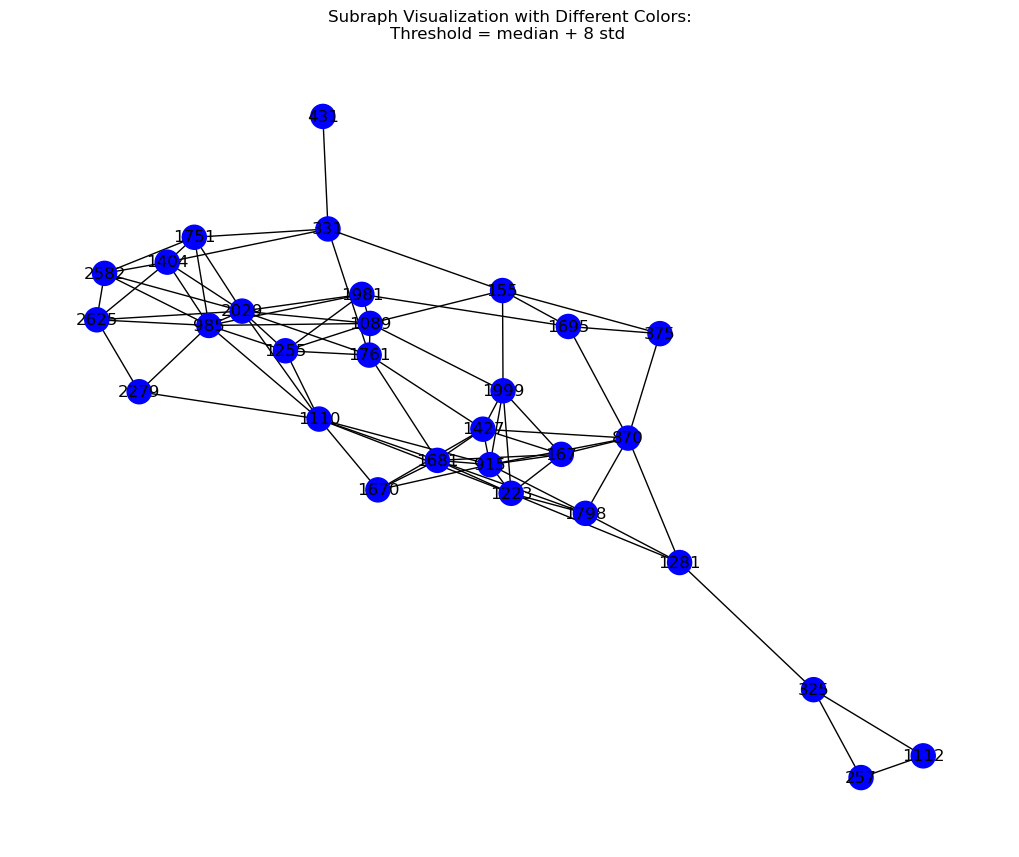

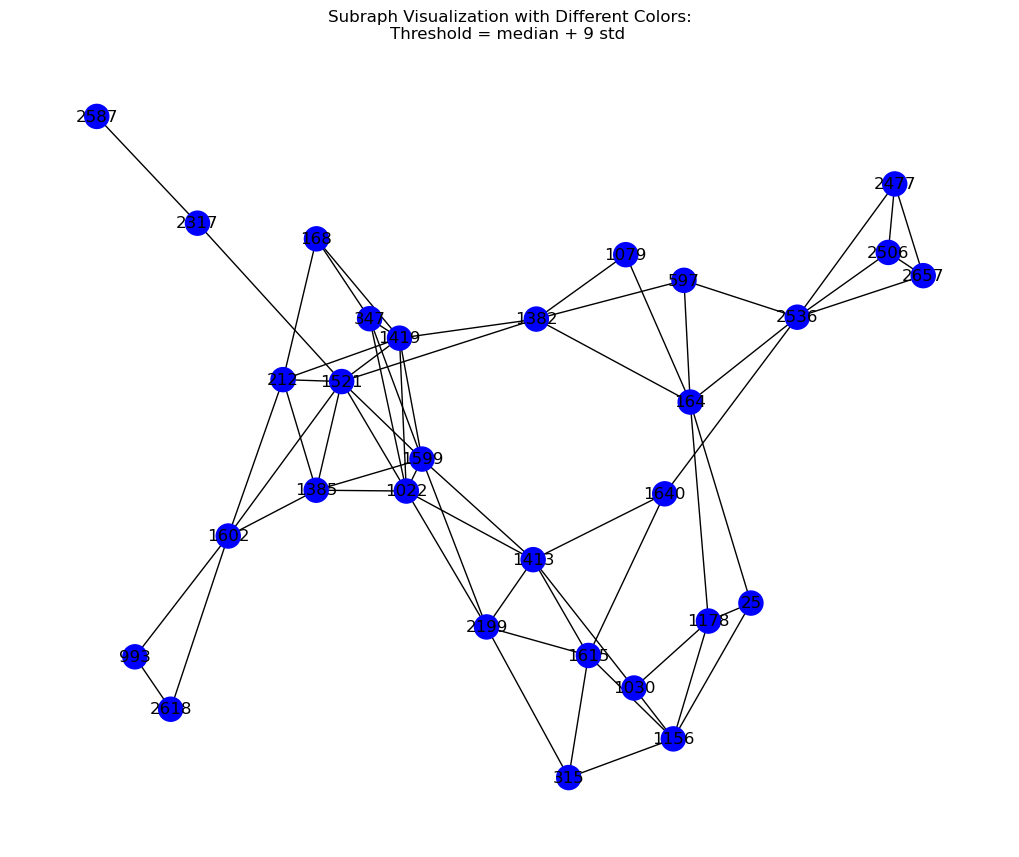

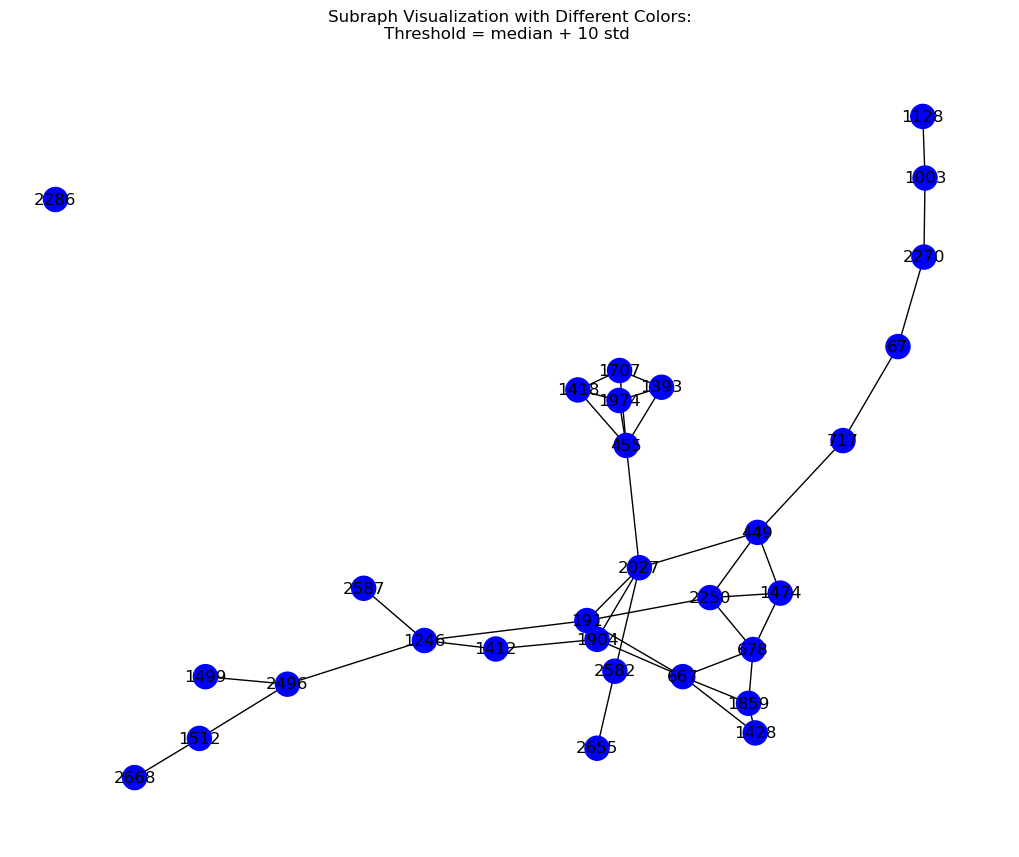

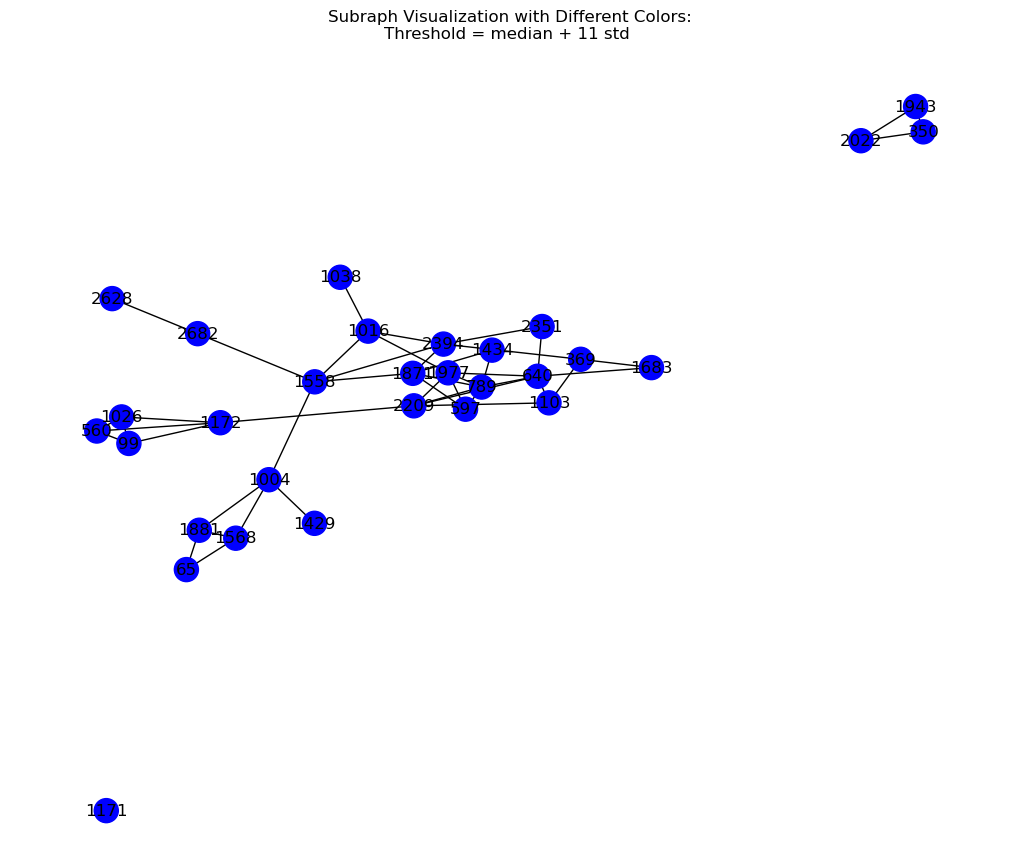

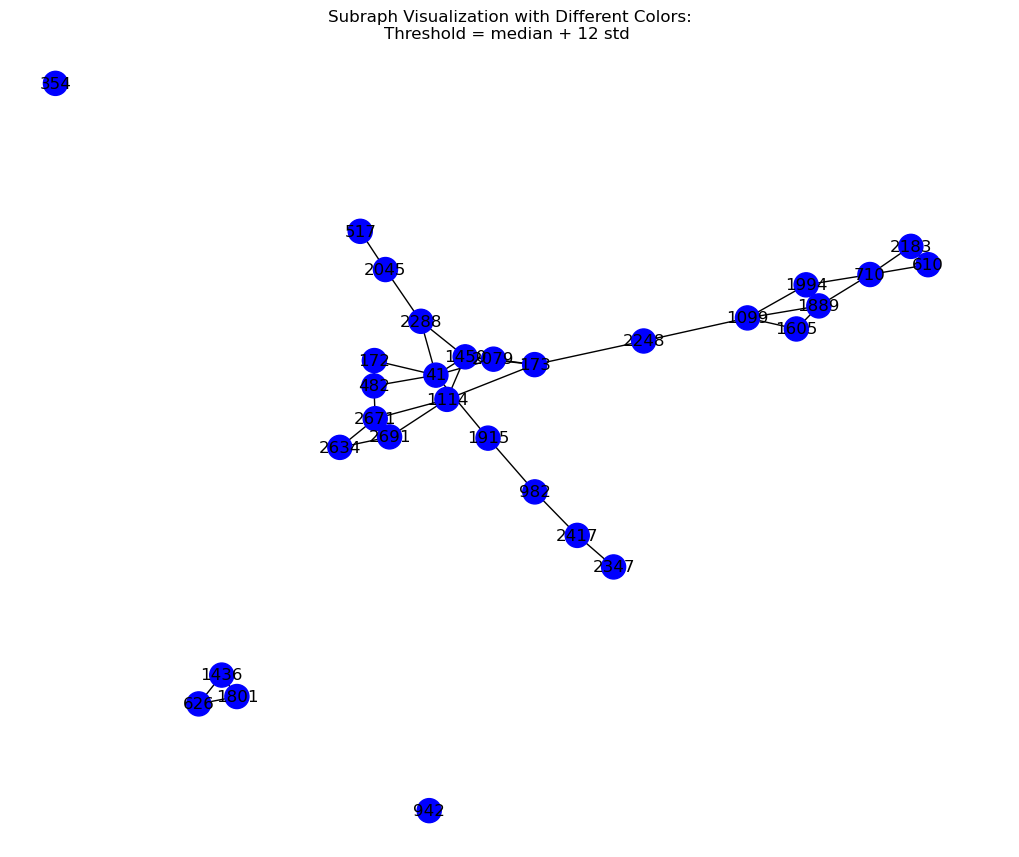

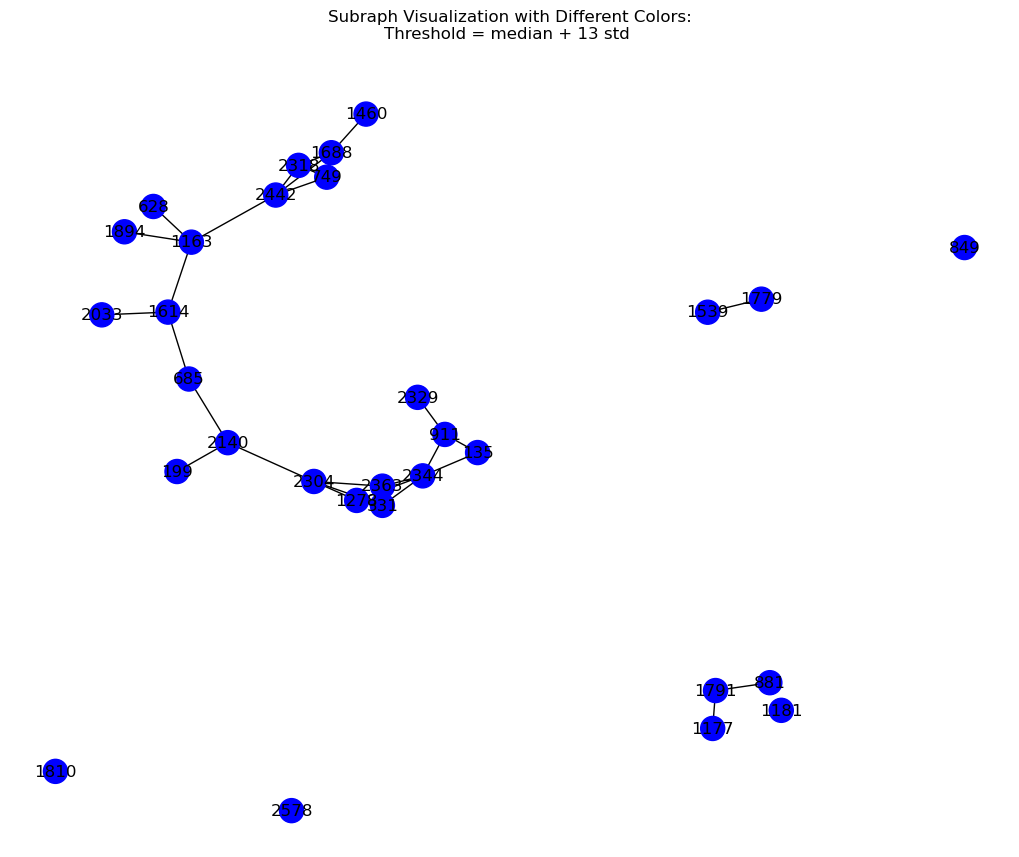

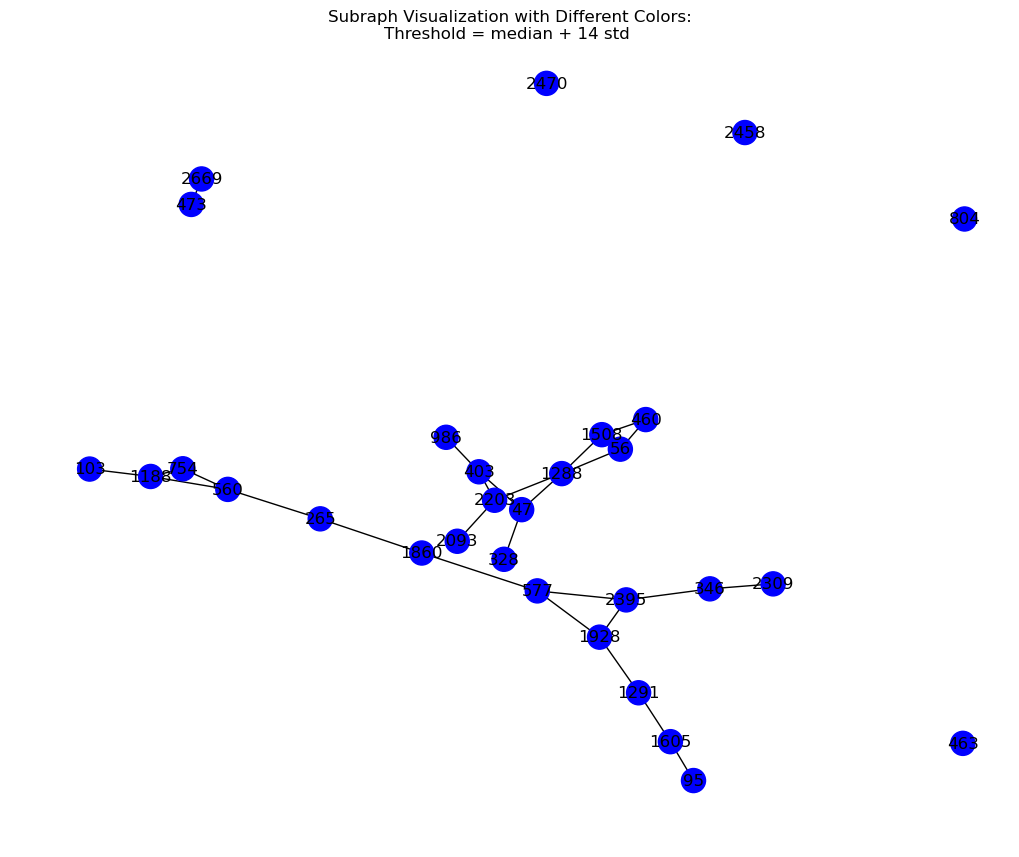

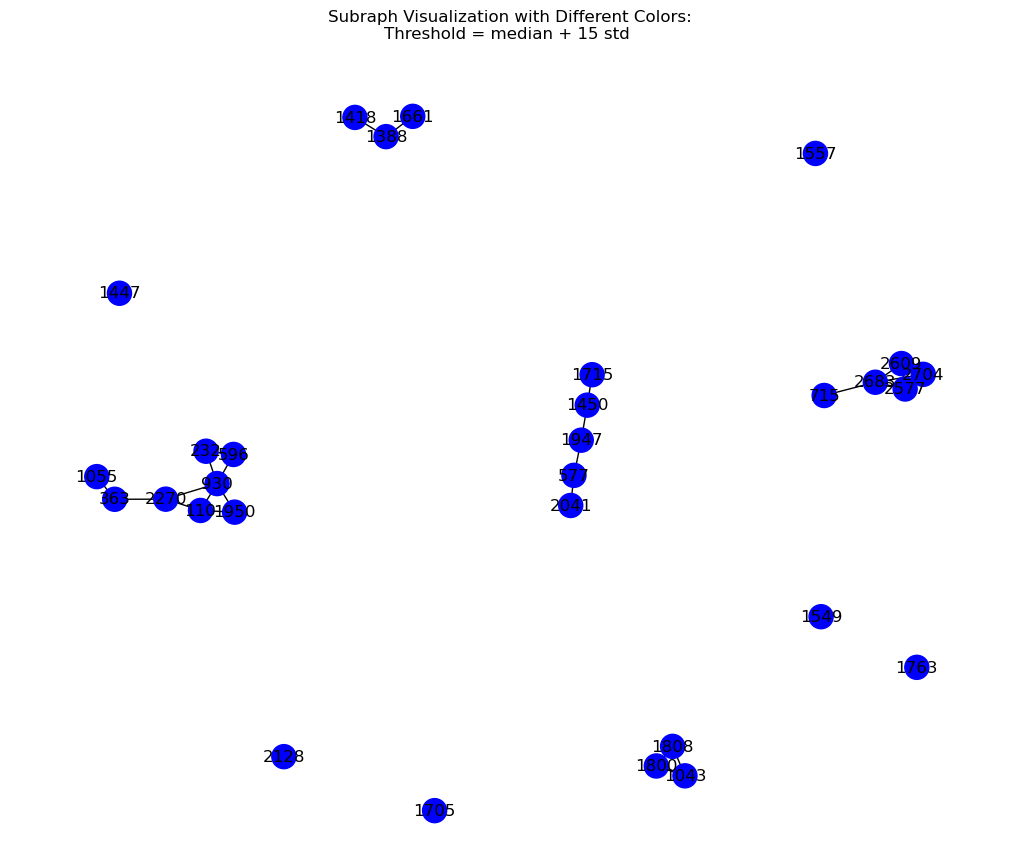

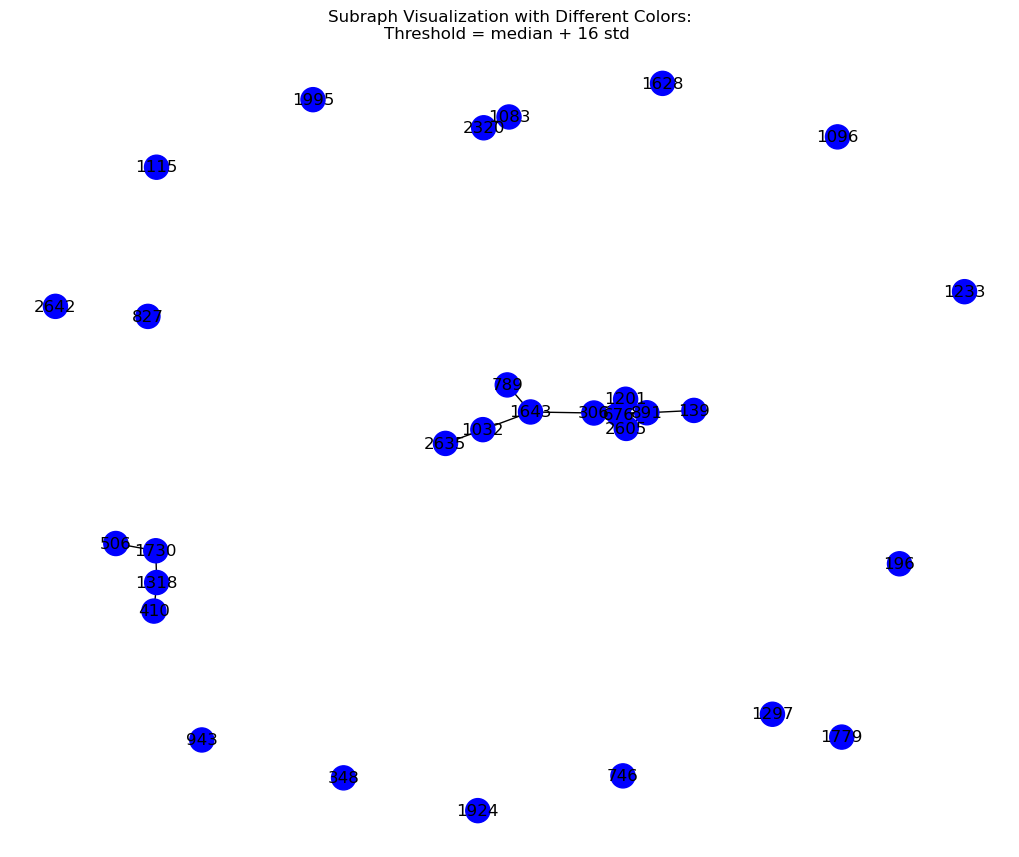

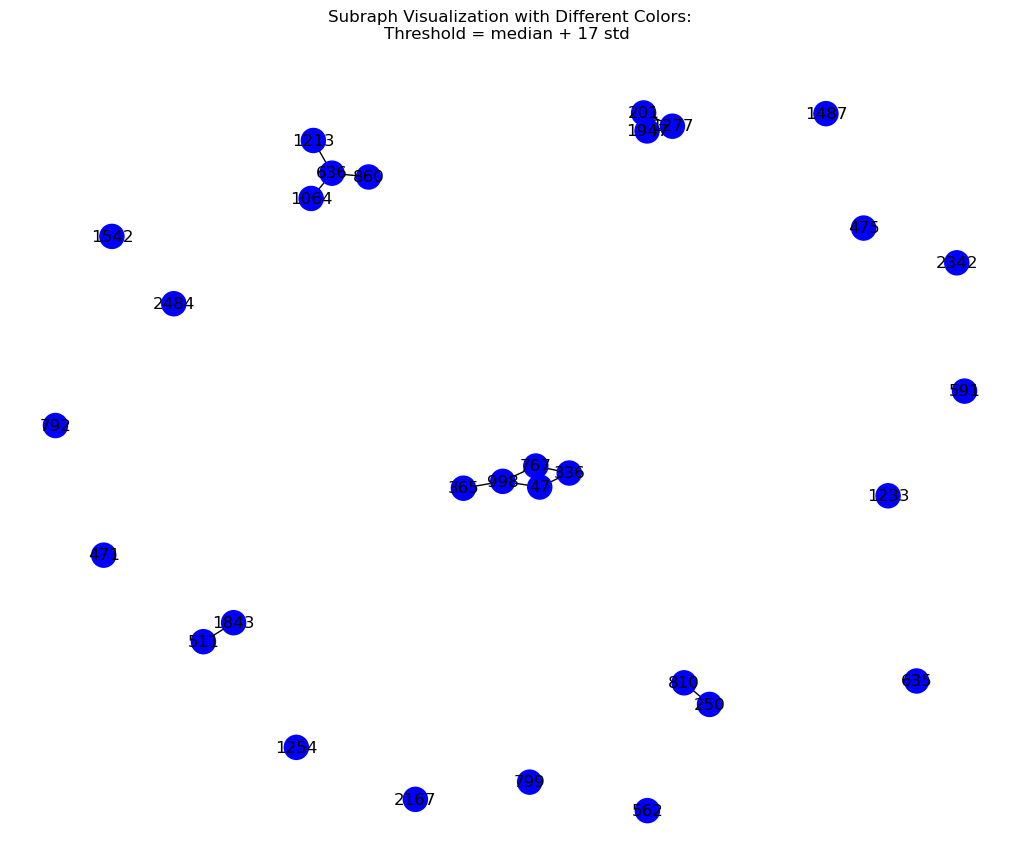

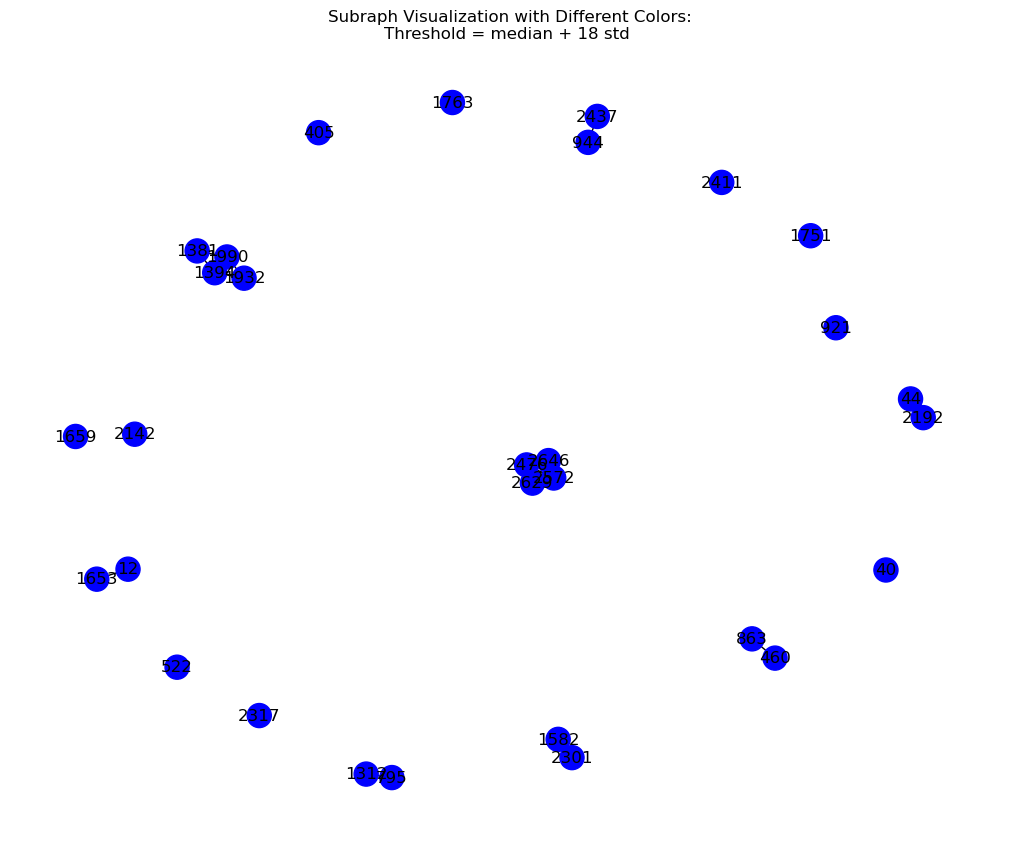

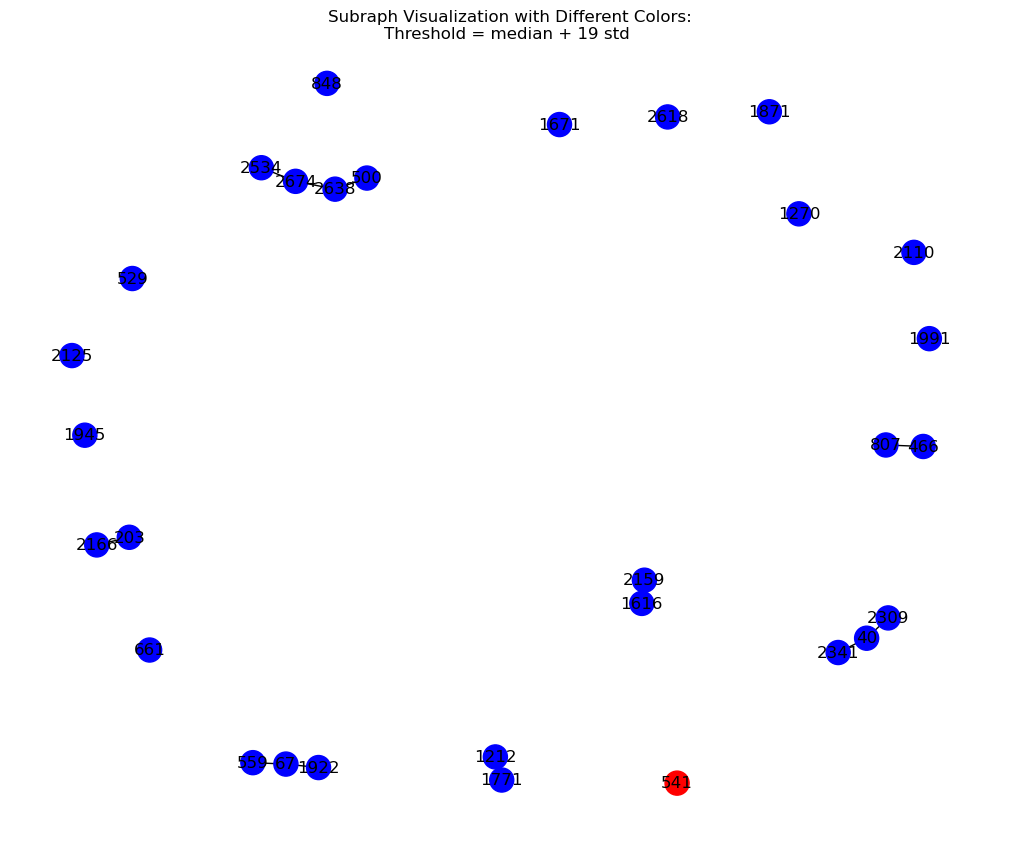

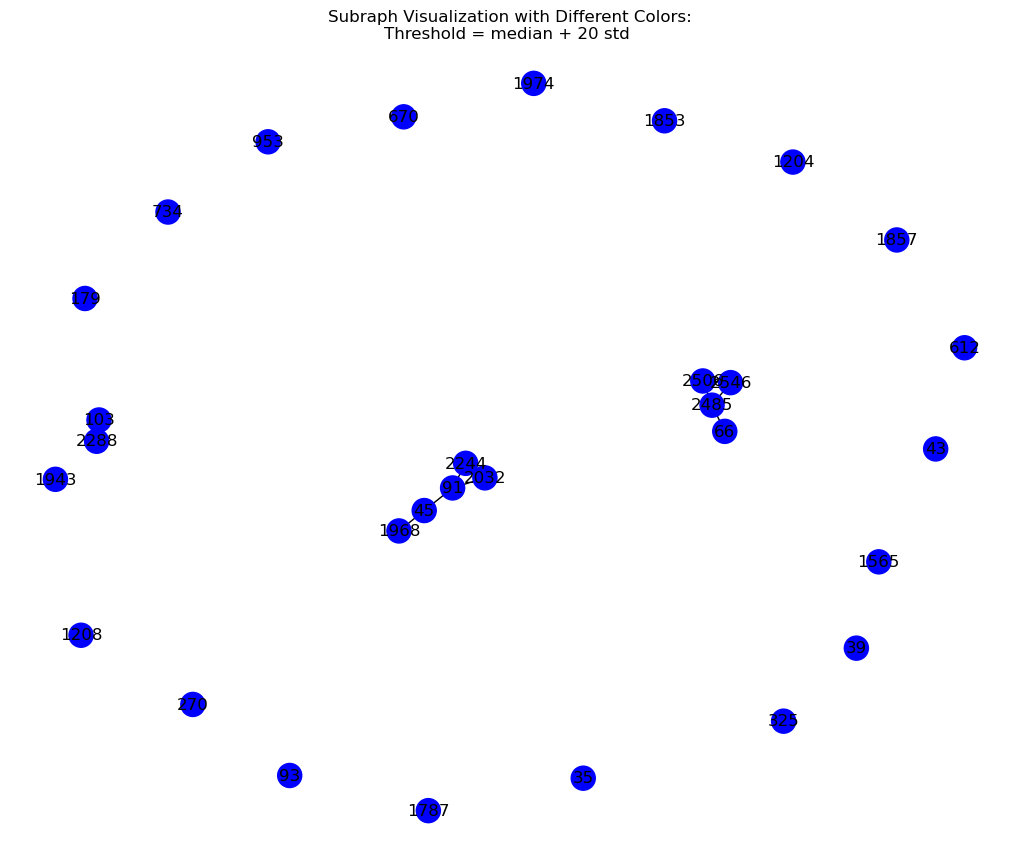

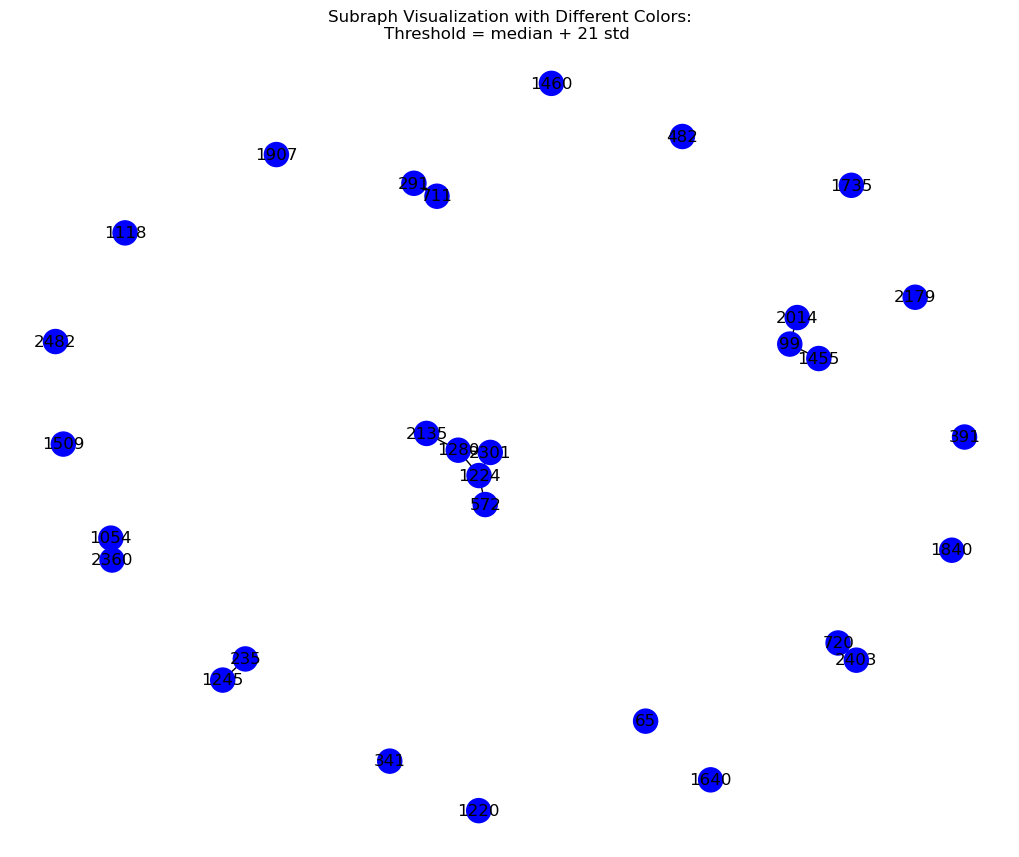

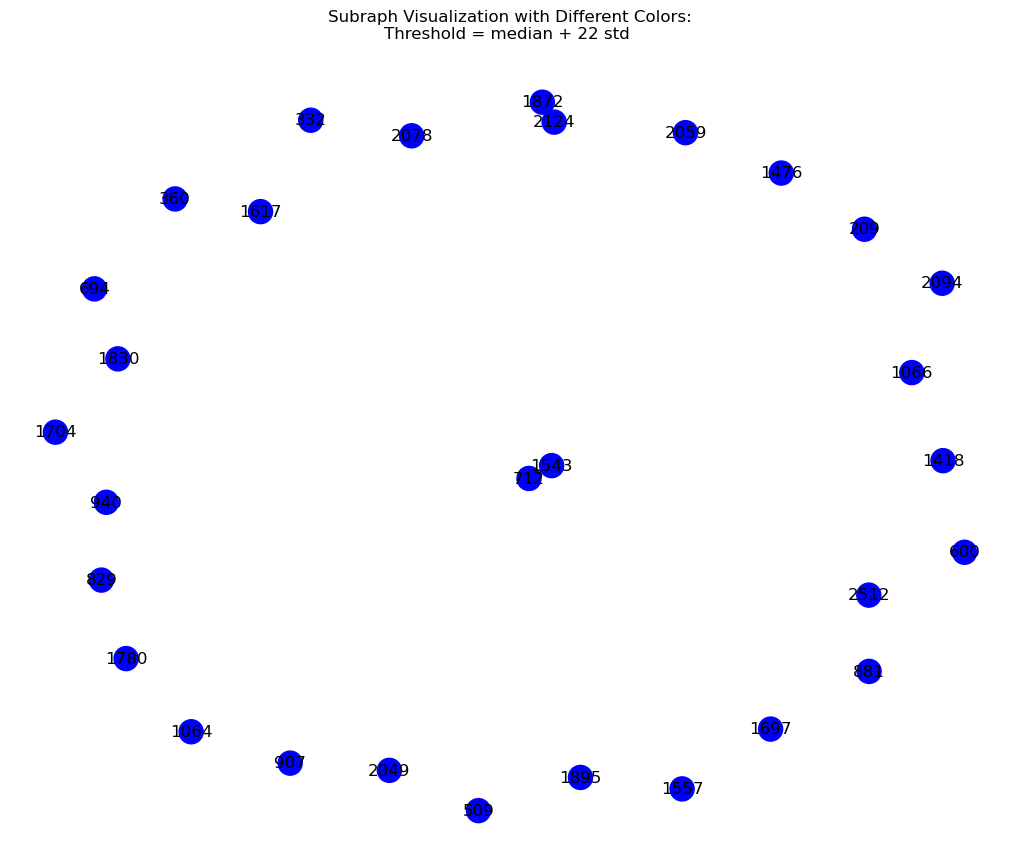

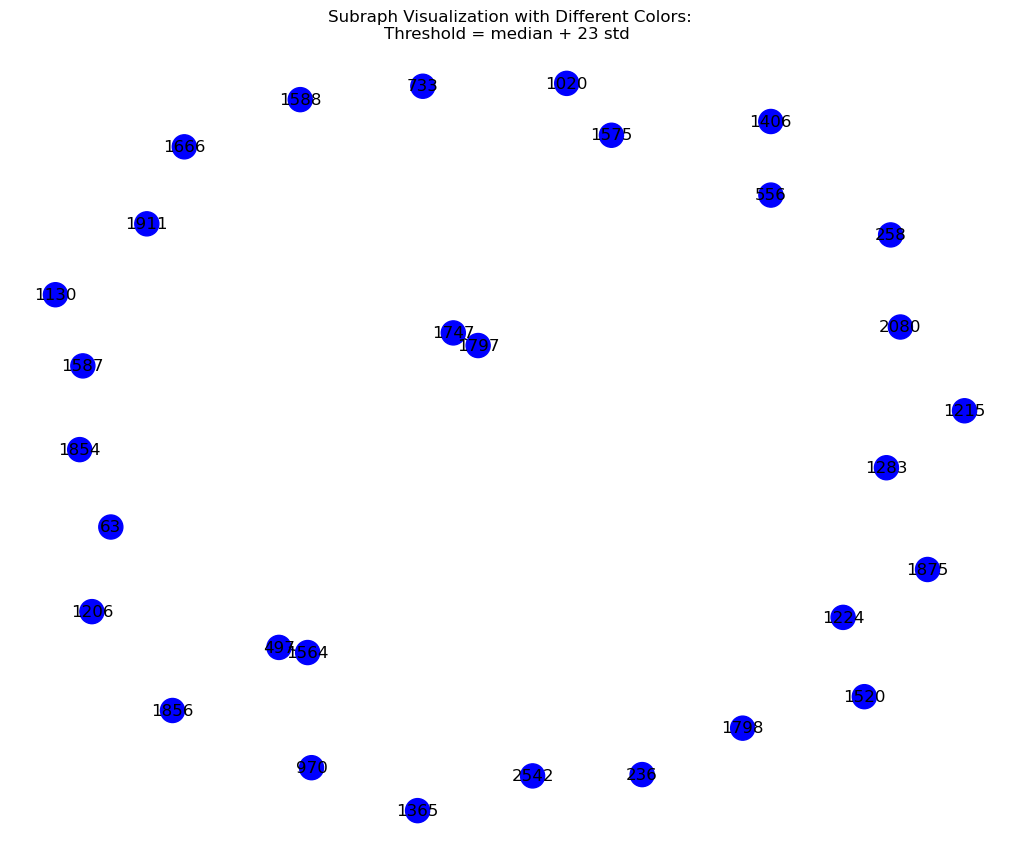

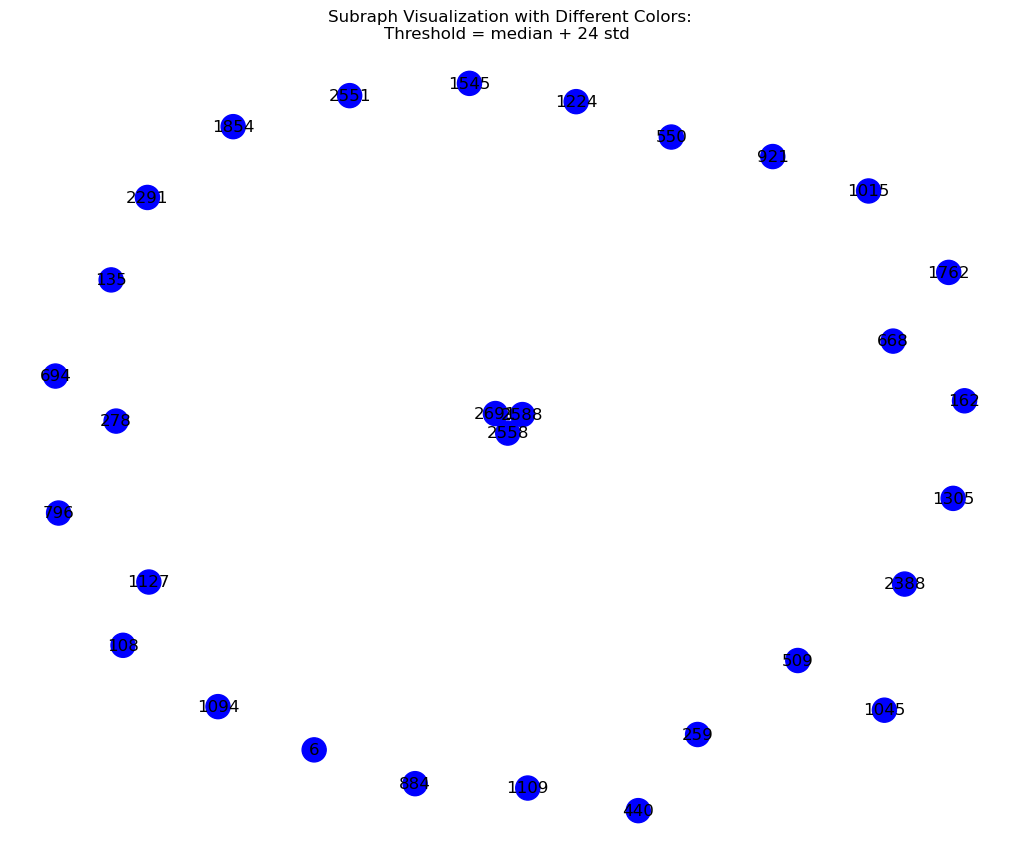

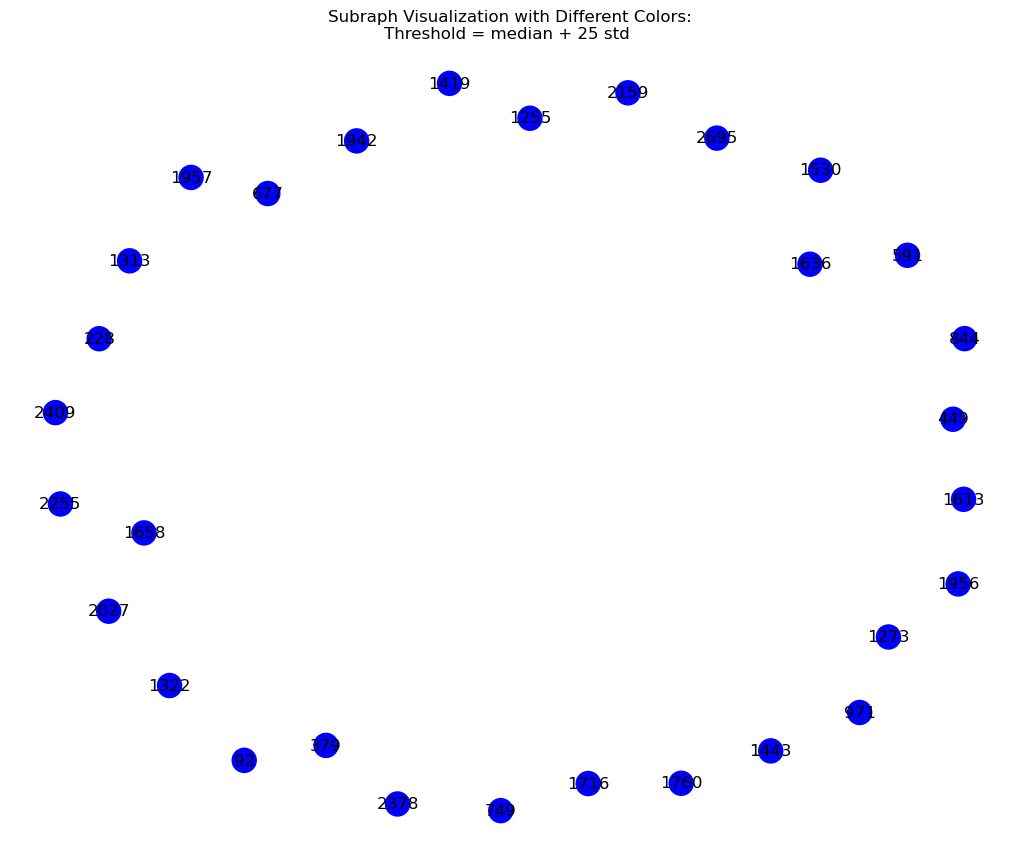

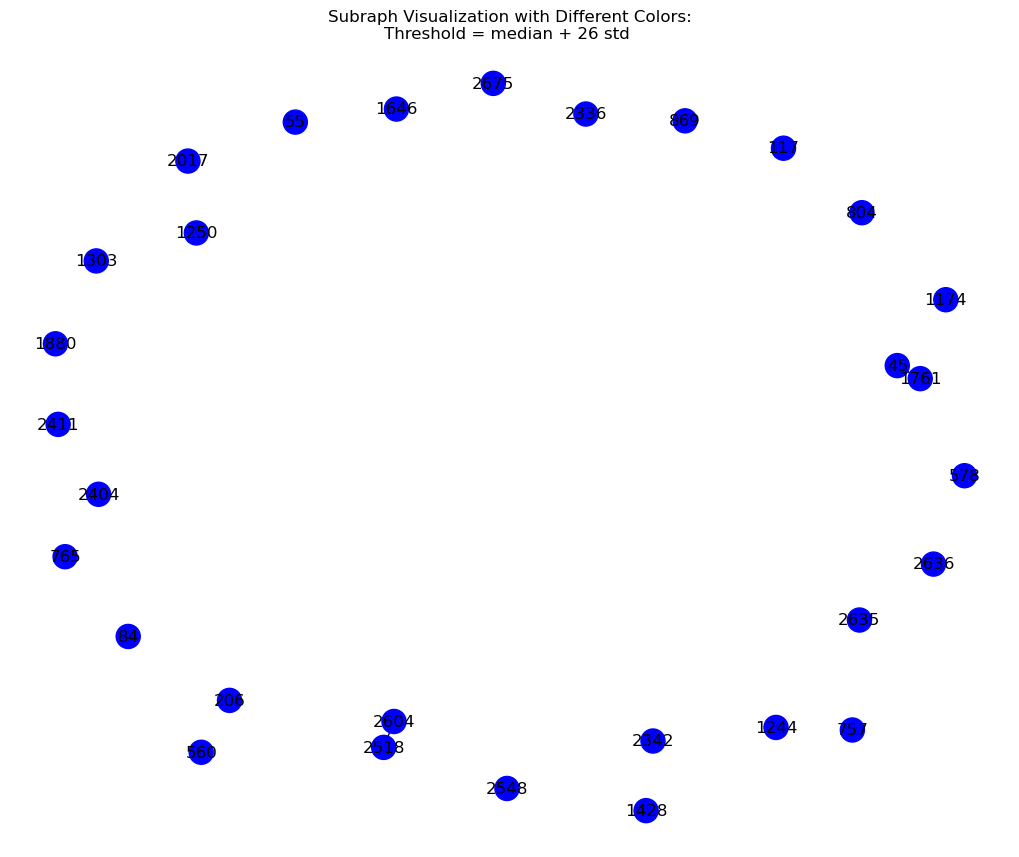

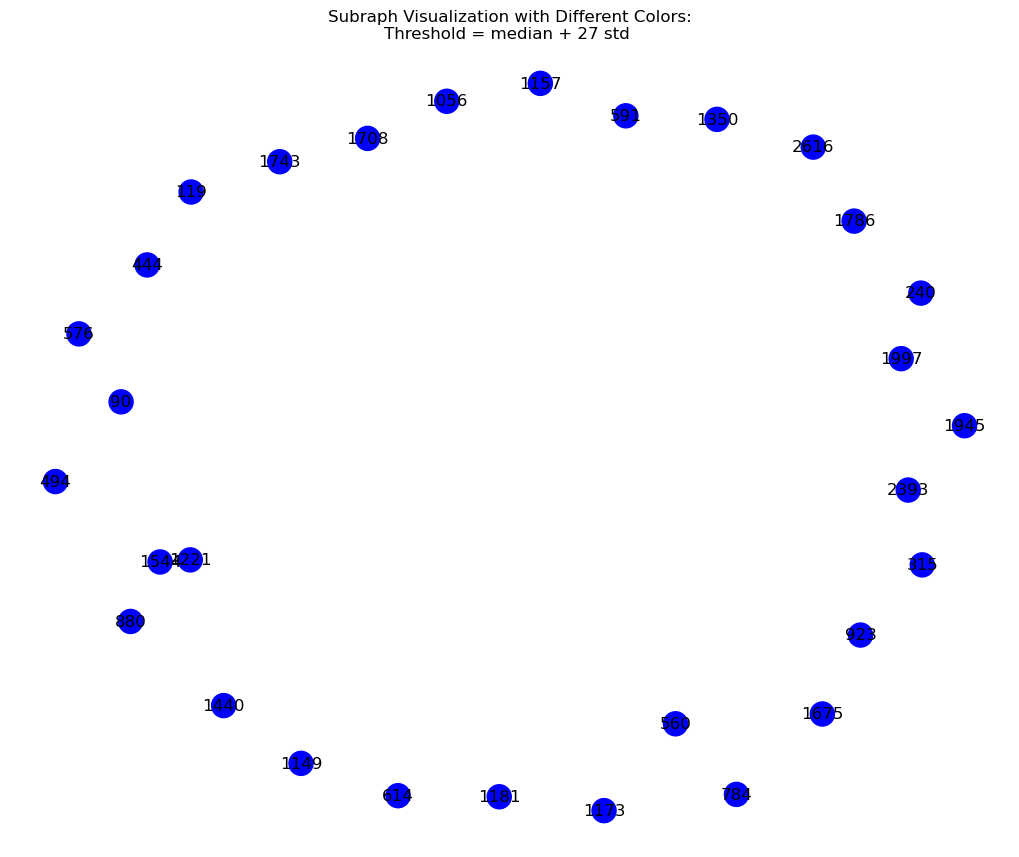

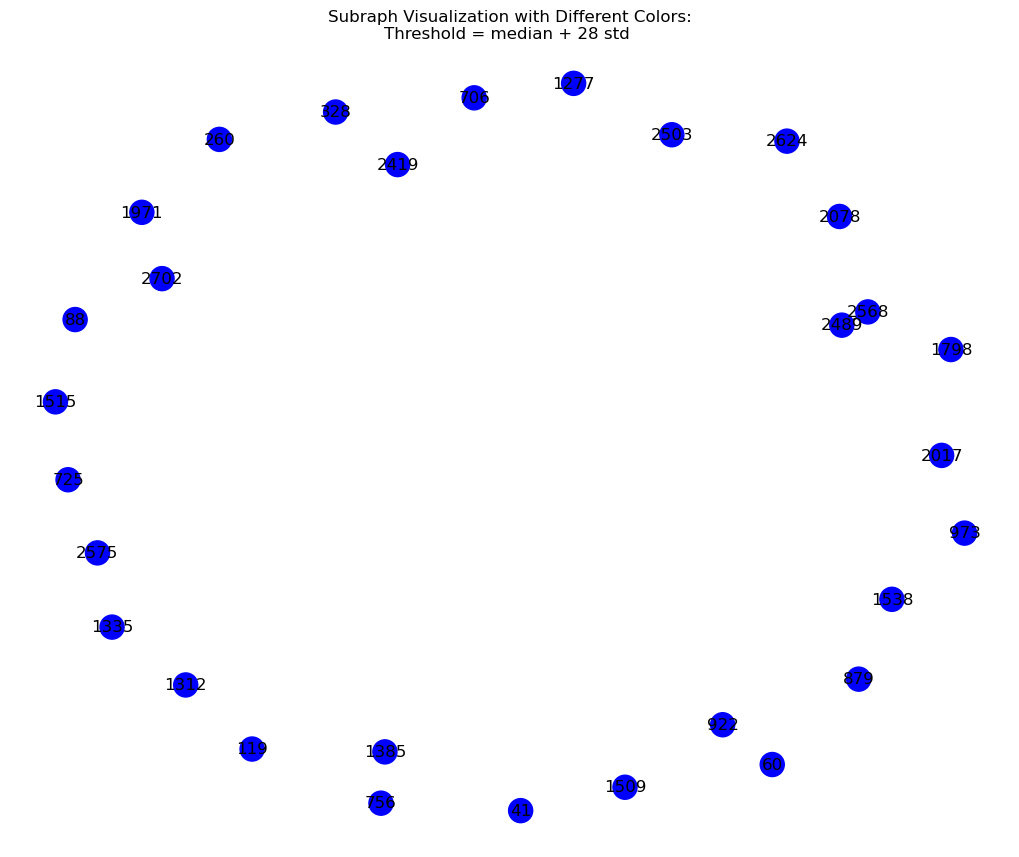

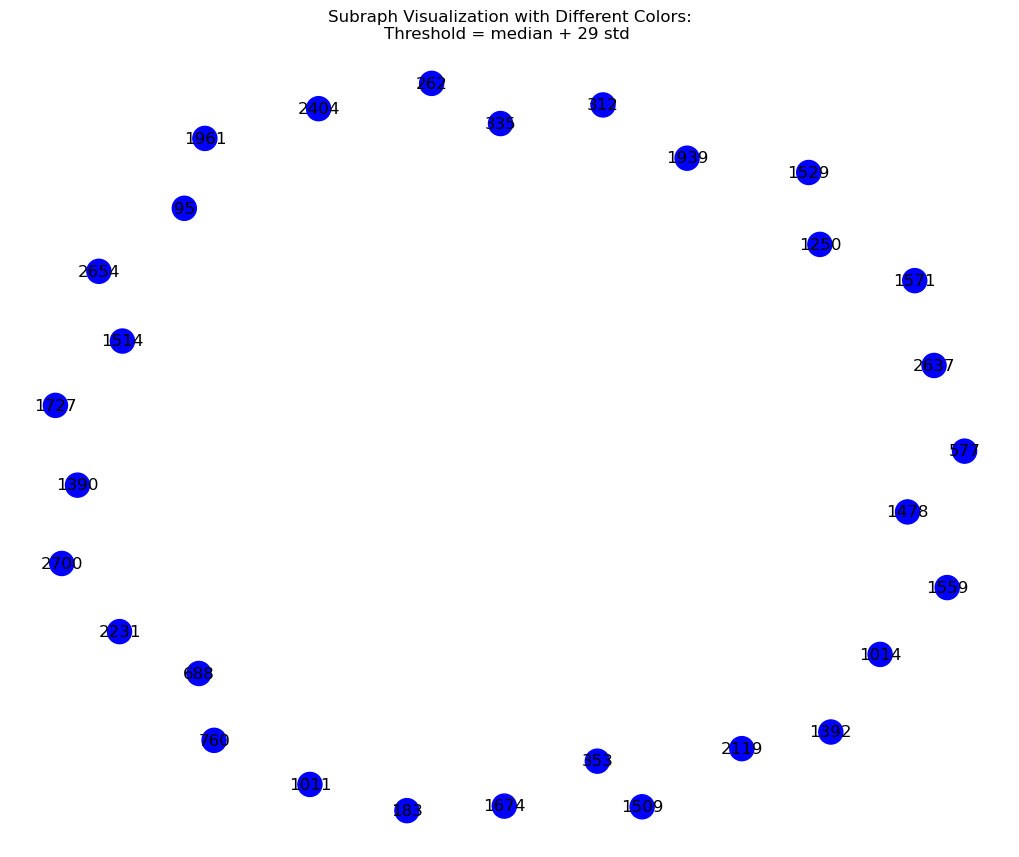

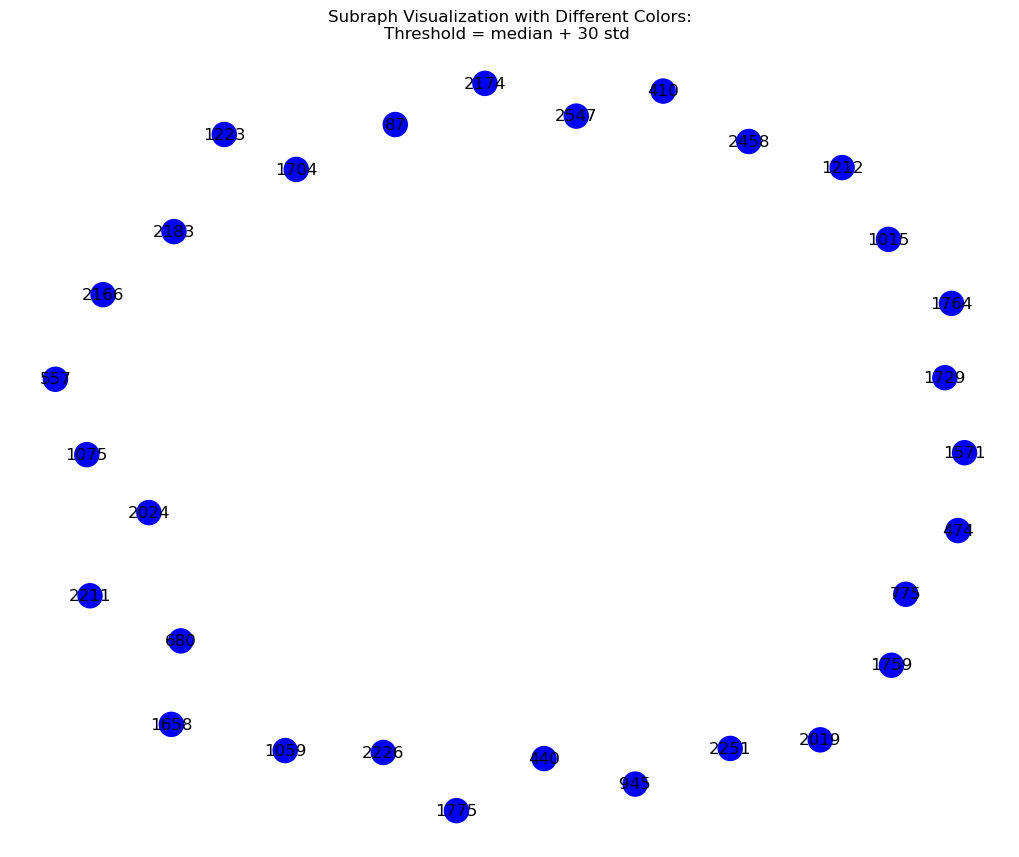

In [27]:
# 圖
import matplotlib.pyplot as plt
import random
for idx,G in tqdm(enumerate(graph),desc="plot..."):
    subset_nodes = random.sample(G.nodes(), k=30)
    subgraph = G.subgraph(subset_nodes)

    # 定義顏色映射
    color_map = {0: 'blue', 1: 'red'}

    # 根據類別為節點指定顏色
    node_colors = [color_map[G.nodes[node]['Class']] for node in subgraph.nodes()]

    # 繪製子圖
    plt.figure(figsize=(10, 8))
    nx.draw(subgraph, with_labels=True, node_color=node_colors)
    plt.title(f"Subraph Visualization with Different Colors:\nThreshold = median + {idx} std ")
    # 保存图为文件
    plt.savefig(f'./plot_G/median_add_{idx}_std.png')  # 将图保存为 PNG 格式
    # plt.show()

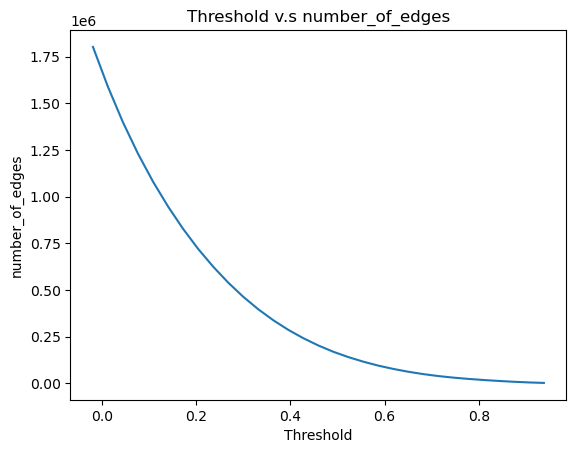

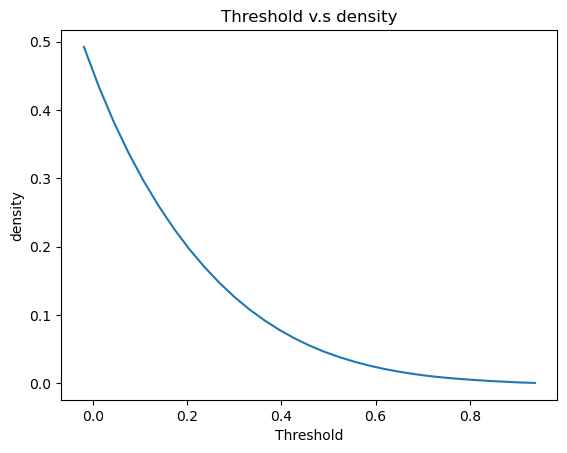

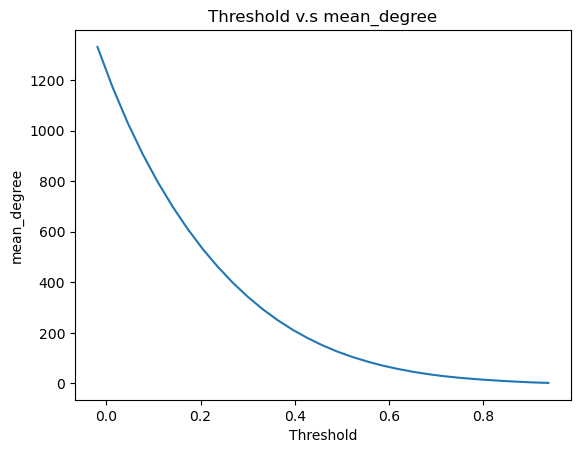

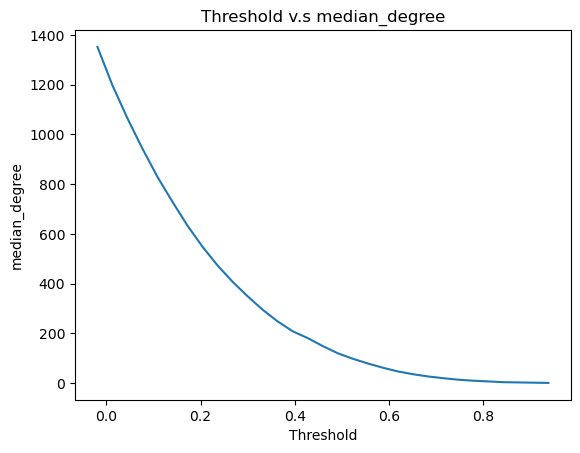

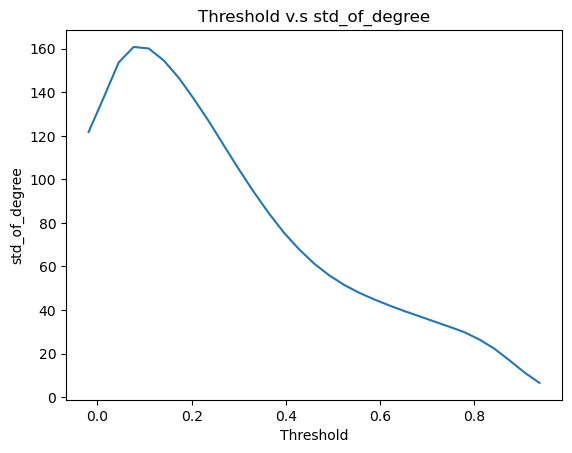

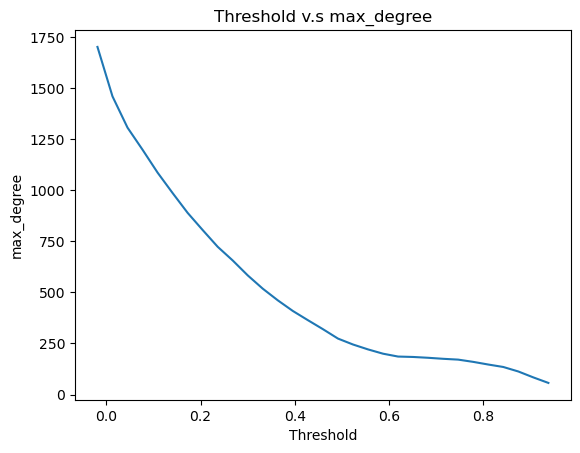

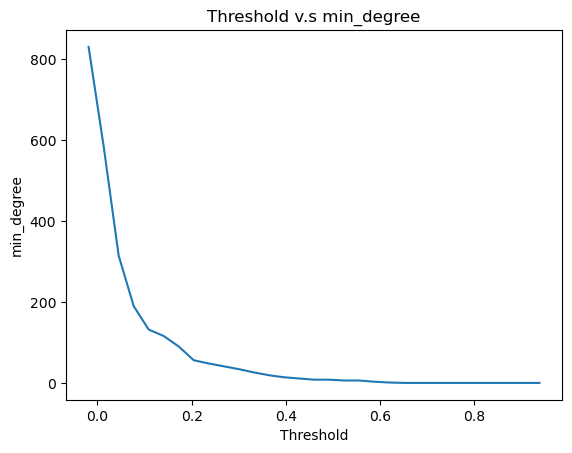

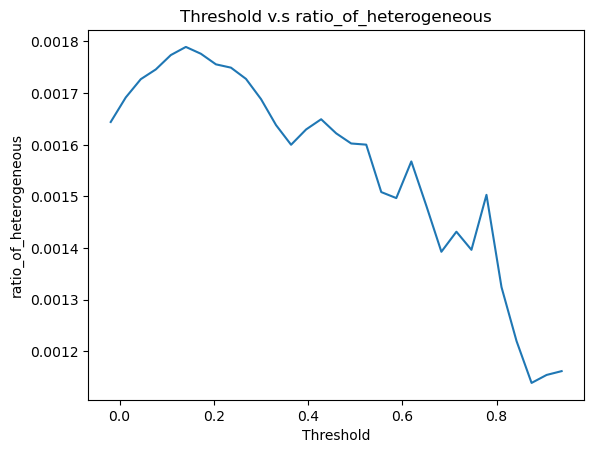

In [28]:
## plot graph construction experiments result
x=data_dic['threshold']
for key in data_dic:
    if key=='graph' or key=='threshold' or key=='number_of_nodes':
        continue
    y=data_dic[key]
    plt.figure()
    plt.plot(x,y)
    plt.title(f"Threshold v.s {key}")
    plt.xlabel("Threshold")
    plt.ylabel(f"{key}")
    plt.savefig(f"./experiments_plt/threshold_vs_{key}")
    plt.show()
    
    

In [29]:
# node_features = {node: data for node, data in G.nodes(data=True)}
# print(node_features[0])
# print(list(node_features[0].values()))

In [30]:
import os
import pickle
def read_graph(type):
    # 讀所有graph
    folder_path = './graph/'+type+"/"
    graph_dic = {}
    # 遍歷資料夾下的所有檔案
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # print(file_path)
        # 檢查是否是.pkl檔案
        if filename.endswith(".pickle"):
            # 讀取.pkl檔案
            try:
                with open(file_path, "rb") as file:
                    G = pickle.load(file)
                    # 在這裡可以對讀取的資料進行處理
                    print(f"從 '{file_path}' 讀取到資料：{G}")
                    threshold = float(os.path.splitext(filename)[0])
                    graph_dic[threshold] = G
            except Exception as e:
                print(f"讀取 '{file_path}' 時發生錯誤：{e}")
    return graph_dic


In [31]:
graph_dic = read_graph("train")
graph_dic_test = read_graph("test")

從 './graph/train/0.5552715549293858.pickle' 讀取到資料：Graph with 2706 nodes and 116010 edges
從 './graph/train/0.013052660488412922.pickle' 讀取到資料：Graph with 2706 nodes and 1587240 edges
從 './graph/train/0.14063357682746538.pickle' 讀取到資料：Graph with 2706 nodes and 946667 edges
從 './graph/train/0.9380143039465434.pickle' 讀取到資料：Graph with 2706 nodes and 2582 edges
從 './graph/train/0.8742238457770171.pickle' 讀取到資料：Graph with 2706 nodes and 8779 edges
從 './graph/train/0.42769063859033346.pickle' 讀取到資料：Graph with 2706 nodes and 241899 edges
從 './graph/train/0.8423286166922539.pickle' 讀取到資料：Graph with 2706 nodes and 13113 edges
從 './graph/train/0.10873834774270227.pickle' 讀取到資料：Graph with 2706 nodes and 1079663 edges
從 './graph/train/0.587166784014149.pickle' 讀取到資料：Graph with 2706 nodes and 94866 edges
從 './graph/train/0.39579540950557035.pickle' 讀取到資料：Graph with 2706 nodes and 286557 edges
從 './graph/train/0.6190620130989122.pickle' 讀取到資料：Graph with 2706 nodes and 77180 edges
從 './graph/train/0.07

In [32]:
print(graph_dic)
print(graph_dic_test)

{0.5552715549293858: <networkx.classes.graph.Graph object at 0x7f11377c7ee0>, 0.013052660488412922: <networkx.classes.graph.Graph object at 0x7f1137866af0>, 0.14063357682746538: <networkx.classes.graph.Graph object at 0x7f11378666d0>, 0.9380143039465434: <networkx.classes.graph.Graph object at 0x7f13a81598b0>, 0.8742238457770171: <networkx.classes.graph.Graph object at 0x7f1137866c10>, 0.42769063859033346: <networkx.classes.graph.Graph object at 0x7f1137abf640>, 0.8423286166922539: <networkx.classes.graph.Graph object at 0x7f11379f13a0>, 0.10873834774270227: <networkx.classes.graph.Graph object at 0x7f1137b86340>, 0.587166784014149: <networkx.classes.graph.Graph object at 0x7f1137b86040>, 0.39579540950557035: <networkx.classes.graph.Graph object at 0x7f1137b86460>, 0.6190620130989122: <networkx.classes.graph.Graph object at 0x7f1137b86970>, 0.07684311865793916: <networkx.classes.graph.Graph object at 0x7f1137b86160>, 0.9061190748617802: <networkx.classes.graph.Graph object at 0x7f1137b

In [33]:
# networkx graph 轉pytorch Data
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv

def G_to_data(graph_dic):
    all_data = []
    for threshold in tqdm(sorted(graph_dic.keys())):
        G = graph_dic[threshold]
        x, y, edge_index = [], [], []
        for node in G.nodes():
            x.append(list(G.nodes[node].values())[:-1])
            y.append(list(G.nodes[node].values())[-1])
    
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()
    
        data = Data(x=x, edge_index=edge_index, y=y)
        data['threshold'] = threshold
        all_data.append(data)
    return all_data

/home/p76121194/miniconda3/envs/dl_project/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
all_data = G_to_data(graph_dic)
all_data_test = G_to_data(graph_dic_test)

  0%|          | 0/31 [00:00<?, ?it/s]/tmp/ipykernel_59216/572078566.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(y, dtype=torch.long)
100%|██████████| 31/31 [00:05<00:00,  5.79it/s]


In [35]:
print(all_data)

[Data(x=[2706, 30], edge_index=[2, 1801581], y=[2706], threshold=-0.018842568596350195), Data(x=[2706, 30], edge_index=[2, 1587240], y=[2706], threshold=0.013052660488412922), Data(x=[2706, 30], edge_index=[2, 1397227], y=[2706], threshold=0.04494788957317604), Data(x=[2706, 30], edge_index=[2, 1229180], y=[2706], threshold=0.07684311865793916), Data(x=[2706, 30], edge_index=[2, 1079663], y=[2706], threshold=0.10873834774270227), Data(x=[2706, 30], edge_index=[2, 946667], y=[2706], threshold=0.14063357682746538), Data(x=[2706, 30], edge_index=[2, 827050], y=[2706], threshold=0.17252880591222852), Data(x=[2706, 30], edge_index=[2, 719932], y=[2706], threshold=0.20442403499699163), Data(x=[2706, 30], edge_index=[2, 624817], y=[2706], threshold=0.23631926408175474), Data(x=[2706, 30], edge_index=[2, 539493], y=[2706], threshold=0.26821449316651785), Data(x=[2706, 30], edge_index=[2, 463744], y=[2706], threshold=0.30010972225128096), Data(x=[2706, 30], edge_index=[2, 396806], y=[2706], thr

In [36]:
# gat
from torch_geometric.nn import GATConv
import torch.nn.functional as F
class Encoder_GAT(torch.nn.Module):
    def __init__(self, num_heads, input_dim, hidden_dim, output_dim, num_layers):
        super(Encoder_GAT, self).__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        for i in range(self.num_layers-1):
            if i:
                conv = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)
            else:
                conv = GATConv(input_dim, hidden_dim, heads=num_heads)

            self.convs.append(conv)
            
        if self.num_layers ==1:
            conv = GATConv(input_dim, output_dim)
            self.convs.append(conv)
        elif self.num_layers >1:
            conv = GATConv(hidden_dim * num_heads, output_dim)
            self.convs.append(conv)

    def forward(self, x, edge_index):
        xs = []
        for i in range(self.num_layers):
            x = F.relu(self.convs[i](x, edge_index))
        return x

In [37]:
# model (gat + linear)
import torch.nn as nn
import torch.nn.functional as F
class myGNN(nn.Module):
    def __init__(self, enc_num_heads, enc_input_dim, enc_hidden_dim, enc_num_layers, linear_output_dim):
        super(myGNN, self).__init__()
        # GAT(input、output大小一樣)
        self.encoder_neighbor = Encoder_GAT(enc_num_heads, enc_input_dim, enc_hidden_dim, enc_input_dim, enc_num_layers)
        # linear層
        self.proj_head_neighbor = nn.Linear(enc_input_dim, linear_output_dim)
        self.proj_head_ego = nn.Linear(enc_input_dim, linear_output_dim)

        self.init_emb()
    # embedding初始化
    def init_emb(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight.data)
                # BIASE初始化為0
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
    @staticmethod
    def negative_sample(h_ego, h_neighbor):
        # 返回一个0~n-1的數組，隨機打散
        perm = torch.randperm(h_ego.shape[0])
        # 打亂，作ego-ego negative
        h_ego_neg = h_ego[perm]
        # 打亂，作ego-neigbor negative
        h_neighbor_neg = h_neighbor[perm]
        return h_ego_neg, h_neighbor_neg

    @staticmethod
    def discriminator(x1, x2):
        return -1 * F.cosine_similarity(x1, x2, dim=1).unsqueeze(0)

    def forward(self, x, edge_index):
        # GAT
        h_neighbor = self.encoder_neighbor(x, edge_index)
        h_neighbor = self.proj_head_neighbor(h_neighbor)
        # linear
        h_ego = self.proj_head_ego(x)

        return h_ego, h_neighbor

In [38]:
# train & eval model
import time
from sklearn.metrics import roc_auc_score
import json
import copy
import os
import numpy as np
import torch

def rescale(x):
    return ((x + 1) / 2)*(1-(2e-06)) + 1e-06


def train_model(args, data, model, optimizer, loss_function):
    stats = {
        "best_loss": 1e9,
        "best_epoch": -1,
    }
    model.train()

    label_ones =  torch.ones(1, data.x.shape[0]).to(args["device"])
    label_zeros = torch.zeros(1, data.x.shape[0]).to(args["device"])

    for epoch in tqdm(range(args['num_epoch'])):
        optimizer.zero_grad()
        data = data.to(args['device'])
        # forward(gat+linear)
        h_ego, h_neighbor = model(data.x, data.edge_index)
        h_ego_neg, h_neighbor_neg  = model.negative_sample(h_ego, h_neighbor)
        # 算 -c
        c_neighbor_pos = model.discriminator(h_ego, h_neighbor)
        c_neighbor_neg = model.discriminator(h_ego, h_neighbor_neg)
        c_ego_neg = model.discriminator(h_ego, h_ego_neg)
        # rescal(x) = (x-(-1)) / 2，使介於0~1(原介於-1~1)
        score_pos = rescale(c_neighbor_pos)
        score_aug = rescale(c_neighbor_neg)
        score_nod = rescale(c_ego_neg)
        
        # BCE loss
        # ego-neighbor postive, ego-neighbor negative, ego-ego negative
        loss_pos = loss_function(score_pos, label_zeros)
        loss_aug = loss_function(score_aug, label_ones)
        loss_nod = loss_function(score_nod, label_ones)
        
        loss_sum = loss_pos + args['alpha'] * loss_aug  + args['gamma'] * loss_nod

        loss_sum.backward()
        # 只用postive判斷好壞
        if loss_pos < stats["best_loss"]:
            stats["best_loss"] = loss_pos.item()
            stats["best_epoch"] = epoch
            torch.save(model.state_dict(), args['state_path'])
        optimizer.step()

        # if epoch % 100 ==0:
        #     eval_model(args, data, model)


    return stats

def eval_model(args, data, model):
    model.eval()
    with torch.no_grad():
        data = data.to(args["device"])
        h_ego, h_neighbor = model(data.x, data.edge_index)
        c_neighbor_pos = model.discriminator(h_ego, h_neighbor)
        
        y_true = (data.y).detach().cpu().tolist()
        y_score = c_neighbor_pos.squeeze().detach().cpu().tolist()
        auc = roc_auc_score(y_true, y_score)
        print("auc: ",  auc)
    return auc


In [39]:
# run
import random

def set_random_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def run_experiment(args, data_train, data_test):
    set_random_seeds(args['seed'])
    # Create model
    model = myGNN(args['enc_num_heads'], args['enc_input_dim'], args['enc_hidden_dim'],  args['enc_num_layers'], args["linear_output_dim"])
    model.to(args['device'])
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=args['lr'],
                                 weight_decay=args['weight_decay'])
    loss_function = torch.nn.BCELoss()
    # train
    stats = train_model(
        args, data, model, optimizer, loss_function
    )
    # eval
    model.load_state_dict(torch.load(args["state_path"]))
    auc = eval_model(args, data_test, model)
    stats["AUC"] = auc

    return model, stats

In [40]:
# 參數
args = {"lr": 5e-4, 
        "alpha": 0.3, 
        "gamma": 0.4, 
        "state_path": "model.pkl", 
        "device": "cuda:0", 
        "seed": 1, 
        "num_epoch": 500, 
        "weight_decay": 0.0, 
        "enc_num_heads": 3, 
        "enc_input_dim":all_data[0].x.shape[1], 
        "enc_hidden_dim": 32, 
        "linear_output_dim": 64,
        "enc_num_layers":1,
       }

In [41]:
auc_dict = {}
for data, data_test in zip(all_data, all_data_test): 
    print("----------threshod = "+str(data.threshold)+"-----------------")
    model, stats = run_experiment(args, data, data_test)
    auc_dict[data.threshold]= stats["AUC"]

----------threshod = -0.018842568596350195-----------------


100%|██████████| 500/500 [00:06<00:00, 82.18it/s]


auc:  0.7592455621301776
----------threshod = 0.013052660488412922-----------------


100%|██████████| 500/500 [00:05<00:00, 95.10it/s] 


auc:  0.7712647928994082
----------threshod = 0.04494788957317604-----------------


100%|██████████| 500/500 [00:04<00:00, 100.43it/s]


auc:  0.5153476331360947
----------threshod = 0.07684311865793916-----------------


100%|██████████| 500/500 [00:04<00:00, 107.76it/s]


auc:  0.5179363905325444
----------threshod = 0.10873834774270227-----------------


100%|██████████| 500/500 [00:04<00:00, 113.78it/s]


auc:  0.48650147928994086
----------threshod = 0.14063357682746538-----------------


100%|██████████| 500/500 [00:04<00:00, 117.97it/s]


auc:  0.48206360946745563
----------threshod = 0.17252880591222852-----------------


100%|██████████| 500/500 [00:04<00:00, 123.38it/s]


auc:  0.45765532544378695
----------threshod = 0.20442403499699163-----------------


100%|██████████| 500/500 [00:03<00:00, 127.48it/s]


auc:  0.453957100591716
----------threshod = 0.23631926408175474-----------------


100%|██████████| 500/500 [00:03<00:00, 131.52it/s]


auc:  0.4423076923076923
----------threshod = 0.26821449316651785-----------------


100%|██████████| 500/500 [00:03<00:00, 135.19it/s]


auc:  0.44045857988165676
----------threshod = 0.30010972225128096-----------------


100%|██████████| 500/500 [00:03<00:00, 138.54it/s]


auc:  0.4397189349112426
----------threshod = 0.3320049513360441-----------------


100%|██████████| 500/500 [00:03<00:00, 141.85it/s]


auc:  0.40994822485207105
----------threshod = 0.36390018042080724-----------------


100%|██████████| 500/500 [00:03<00:00, 143.01it/s]


auc:  0.4093934911242604
----------threshod = 0.39579540950557035-----------------


100%|██████████| 500/500 [00:03<00:00, 143.13it/s]


auc:  0.3901627218934911
----------threshod = 0.42769063859033346-----------------


100%|██████████| 500/500 [00:03<00:00, 144.67it/s]


auc:  0.37832840236686394
----------threshod = 0.45958586767509657-----------------


100%|██████████| 500/500 [00:03<00:00, 144.28it/s]


auc:  0.13997781065088755
----------threshod = 0.4914810967598597-----------------


100%|██████████| 500/500 [00:03<00:00, 145.46it/s]


auc:  0.7220784023668639
----------threshod = 0.5233763258446229-----------------


100%|██████████| 500/500 [00:03<00:00, 144.67it/s]


auc:  0.7137573964497042
----------threshod = 0.5552715549293858-----------------


100%|██████████| 500/500 [00:03<00:00, 142.06it/s]


auc:  0.680473372781065
----------threshod = 0.587166784014149-----------------


100%|██████████| 500/500 [00:03<00:00, 143.28it/s]


auc:  0.5625
----------threshod = 0.6190620130989122-----------------


100%|██████████| 500/500 [00:03<00:00, 144.53it/s]


auc:  0.567862426035503
----------threshod = 0.6509572421836753-----------------


100%|██████████| 500/500 [00:03<00:00, 142.38it/s]


auc:  0.5421597633136095
----------threshod = 0.6828524712684383-----------------


100%|██████████| 500/500 [00:03<00:00, 144.75it/s]


auc:  0.5743343195266272
----------threshod = 0.7147477003532015-----------------


100%|██████████| 500/500 [00:03<00:00, 142.68it/s]


auc:  0.558801775147929
----------threshod = 0.7466429294379646-----------------


100%|██████████| 500/500 [00:03<00:00, 141.92it/s]


auc:  0.5626849112426036
----------threshod = 0.7785381585227278-----------------


100%|██████████| 500/500 [00:03<00:00, 140.84it/s]


auc:  0.5930103550295858
----------threshod = 0.810433387607491-----------------


100%|██████████| 500/500 [00:03<00:00, 140.31it/s]


auc:  0.6083579881656804
----------threshod = 0.8423286166922539-----------------


100%|██████████| 500/500 [00:03<00:00, 142.59it/s]


auc:  0.6279585798816568
----------threshod = 0.8742238457770171-----------------


100%|██████████| 500/500 [00:03<00:00, 139.85it/s]


auc:  0.7037721893491125
----------threshod = 0.9061190748617802-----------------


100%|██████████| 500/500 [00:03<00:00, 141.00it/s]


auc:  0.7176405325443788
----------threshod = 0.9380143039465434-----------------


100%|██████████| 500/500 [00:03<00:00, 139.57it/s]

auc:  0.7795857988165681


In [42]:
# 使用sorted函數對字典的值進行降序排列

sorted_dict = dict(sorted(auc_dict.items(), key=lambda item: item[1], reverse=True))

# 輸出排序後的字典
print(sorted_dict)

{0.9380143039465434: 0.7795857988165681, 0.013052660488412922: 0.7712647928994082, -0.018842568596350195: 0.7592455621301776, 0.4914810967598597: 0.7220784023668639, 0.9061190748617802: 0.7176405325443788, 0.5233763258446229: 0.7137573964497042, 0.8742238457770171: 0.7037721893491125, 0.5552715549293858: 0.680473372781065, 0.8423286166922539: 0.6279585798816568, 0.810433387607491: 0.6083579881656804, 0.7785381585227278: 0.5930103550295858, 0.6828524712684383: 0.5743343195266272, 0.6190620130989122: 0.567862426035503, 0.7466429294379646: 0.5626849112426036, 0.587166784014149: 0.5625, 0.7147477003532015: 0.558801775147929, 0.6509572421836753: 0.5421597633136095, 0.07684311865793916: 0.5179363905325444, 0.04494788957317604: 0.5153476331360947, 0.10873834774270227: 0.48650147928994086, 0.14063357682746538: 0.48206360946745563, 0.17252880591222852: 0.45765532544378695, 0.20442403499699163: 0.453957100591716, 0.23631926408175474: 0.4423076923076923, 0.26821449316651785: 0.44045857988165676, 

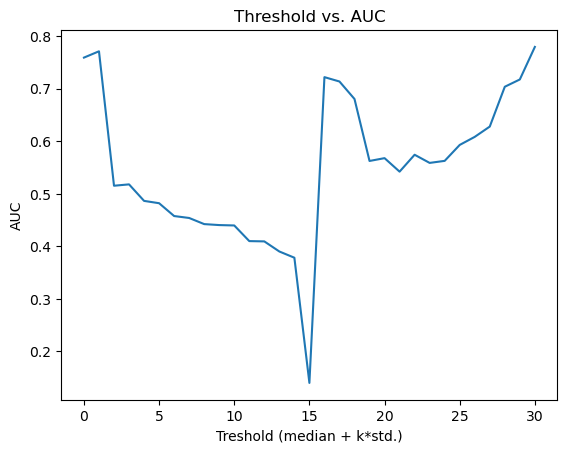

In [43]:
import matplotlib.pyplot as plt

def plot_curve(data):
    keys = [i for i in range(31)]
    values = list(data.values())
    
    plt.plot(keys, values)
    plt.xlabel('Treshold (median + k*std.)')
    plt.ylabel('AUC')
    plt.title('Threshold vs. AUC')
    # plt.grid(True)  # 加入網格線
    plt.show()

plot_curve(auc_dict)
